### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

#physical_devices = tf.config.experimental.list_physical_devices()
#tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000015B0E5330D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 12: NN conversion to TFLite (quantization)

Most of the notebook was based on the *10_ESR_data_preparation.ipynb*. The differences are the neural network conversion (quantization) as preparation to embeeded them in the Raspberry Pi.

***

## Import modules

In [2]:
import os
import warnings
import mimetypes
import time
import pickle

import pandas     as pd
import seaborn    as sns
import numpy      as np

import IPython.display as ipd

from matplotlib  import pyplot  as plt

from collections                 import Counter
from sklearn                     import metrics
from sklearn.ensemble            import RandomForestClassifier
from sklearn.metrics             import classification_report
from tensorflow.keras.models     import load_model

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '12_NN_conversion_quantization_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

cmap_cm     = plt.cm.Blues

tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data preparation

In [4]:
cmap_cm     = plt.cm.Blues

path        = os.path.join(current_path, "_dataset", "US8K_AV")
path_models = os.path.join(current_path, "US8K_AV_saved_models")
path_pic    = os.path.join(current_path, "US8K_AV_results")

path_modelsVal = os.path.join(current_path, "_ESR", "Saved_models_fold_1_validation")
path_arrays    = os.path.join(current_path, "_ESR", "Arrays")

# Check if the folder exists, if not, create it
if not os.path.exists(path_models):
    os.makedirs(path_models)

if not os.path.exists(path_arrays):
    os.makedirs(path_arrays)

nom_dataset               = 'US8K_AV' 
csv_file                  = 'US8K_AV.csv'
fold_name                 = '1'

pkl_features              = 'US8K_AV_features_original.pkl'
pkl_aug_wind_features     = 'US8K_AV_features_windowed.pkl' # not augmented, just windowed
pkl_aug_features          = 'US8K_AV_features_augmented_no_windowing.pkl'

pkl_aug_wind_features_CNN = 'US8K_AV_features_CNN_2D_windowed.pkl' # not augmented, just windowed

DB_ori_from_pkl       = pd.read_pickle(os.path.join(path_models, pkl_features))
DB_aug_from_pkl       = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
DB_aug_CNN2D_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features_CNN))

In [5]:
print(type(DB_ori_from_pkl['Fold'][0][0]))
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [6]:
for fold in np.unique(DB_ori_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold])
    trnsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 430
dbComplete size: 3928

Validation fold: 10
dbComplete_VAL size: 419
dbComplete size: 3939

Validation fold: 2
dbComplete_VAL size: 429
dbComplete size: 3929

Validation fold: 3
dbComplete_VAL size: 482
dbComplete size: 3876

Validation fold: 4
dbComplete_VAL size: 539
dbComplete size: 3819

Validation fold: 5
dbComplete_VAL size: 468
dbComplete size: 3890

Validation fold: 6
dbComplete_VAL size: 400
dbComplete size: 3958

Validation fold: 7
dbComplete_VAL size: 405
dbComplete size: 3953

Validation fold: 8
dbComplete_VAL size: 390
dbComplete size: 3968

Validation fold: 9
dbComplete_VAL size: 396
dbComplete size: 3962



In [7]:
print(type(DB_aug_CNN2D_from_pkl['Fold'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Fold'][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [8]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0]",5,...,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...
4353,"[-0.00048753922, -0.0029013595, -0.0060868477, -0.0077148406, -0.008069417, -0.008534078, -0.008617738, -0.007554673...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.022642,0.008688,0.097807,-0.866208
4354,"[0.0018769287, 0.0028417986, 0.0028369268, 0.003081231, 0.0018484257, 0.0010519021, 0.00044334529, 0.0001646977, -3....",car_horn,"[0, 1, 0, 0, 0]",7,...,0.029405,0.020661,-0.220407,1.997790
4355,"[-0.013202029, -0.020061549, -0.016201336, -0.014081302, -0.0110550765, -0.010160886, -0.012472121, -0.013130652, -0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.034195,-0.002075,0.725307,-0.462707
4356,"[0.0008518654, -0.003709917, -0.009393071, -0.009993944, -0.0063429633, -0.0011706308, 0.0025487966, 0.0038857076, 0...",car_horn,"[0, 1, 0, 0, 0]",7,...,0.029228,-0.005832,-0.330073,-0.796058


In [9]:
DB_aug_CNN2D_from_pkl

,Class_categorical,Class_OHEV,Fold,features
0,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4..."
1,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-..."
2,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3..."
3,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39...."
4,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [..."
...,...,...,...,...
30501,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-16.7570743560791], [-12.688139915466309], [-16.03248405456543], [-15.612970352172852], [-12.660606384277344], [-..."
30502,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-14.313464164733887], [-12.228155136108398], [-15.787863731384277], [-16.082149505615234], [-12.465015411376953],..."
30503,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-24.34674835205078], [-17.664506912231445], [-11.443778038024902], [-11.371871948242188], [-12.617921829223633], ..."
30504,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-20.291765213012695], [-13.778326034545898], [-9.759299278259277], [-8.09199333190918], [-8.728732109069824], [-1..."


In [10]:
for fold in np.unique(DB_aug_CNN2D_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] == fold])
    trnsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 3010
dbComplete size: 27496

Validation fold: 10
dbComplete_VAL size: 2933
dbComplete size: 27573

Validation fold: 2
dbComplete_VAL size: 3003
dbComplete size: 27503

Validation fold: 3
dbComplete_VAL size: 3374
dbComplete size: 27132

Validation fold: 4
dbComplete_VAL size: 3773
dbComplete size: 26733

Validation fold: 5
dbComplete_VAL size: 3276
dbComplete size: 27230

Validation fold: 6
dbComplete_VAL size: 2800
dbComplete size: 27706

Validation fold: 7
dbComplete_VAL size: 2835
dbComplete size: 27671

Validation fold: 8
dbComplete_VAL size: 2730
dbComplete size: 27776

Validation fold: 9
dbComplete_VAL size: 2772
dbComplete size: 27734



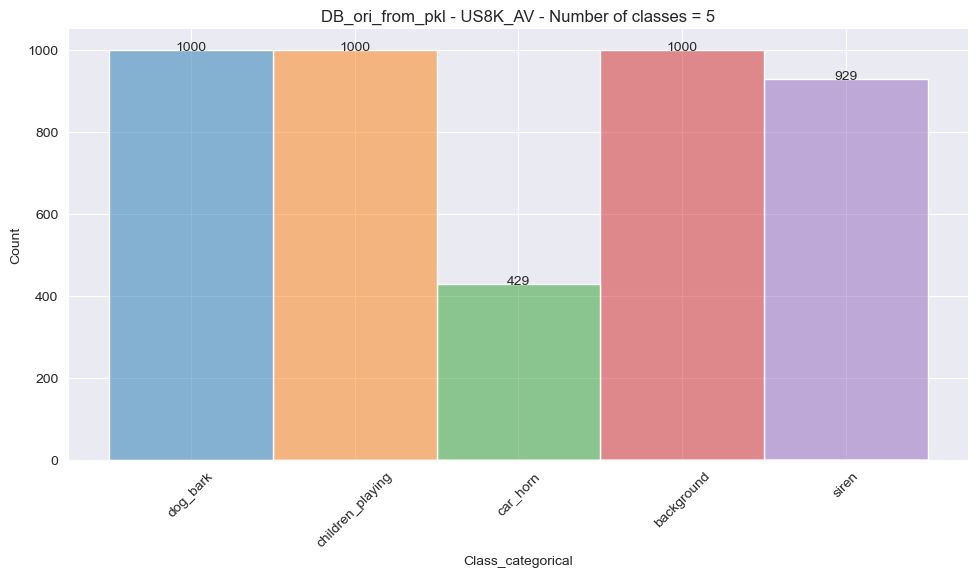

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_ori_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

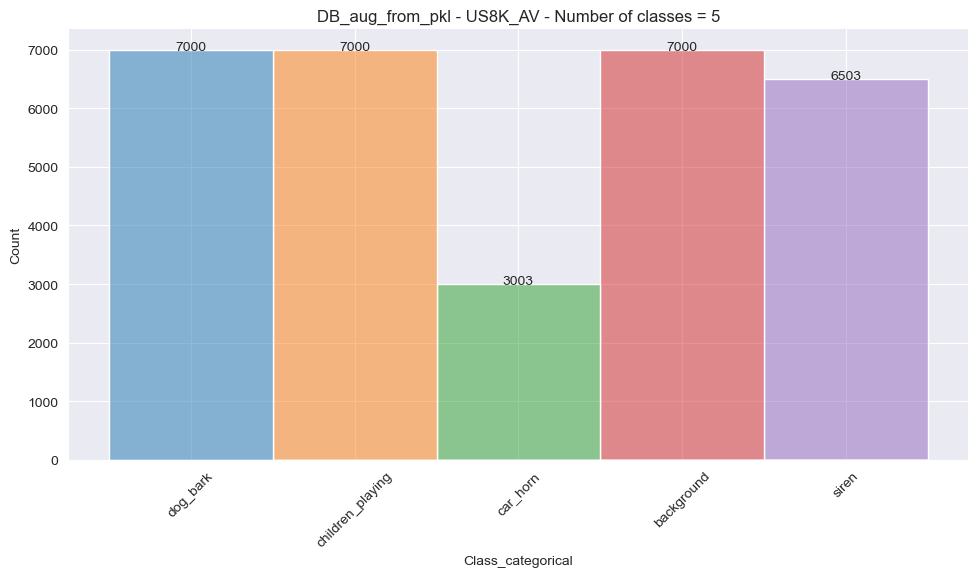

In [12]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

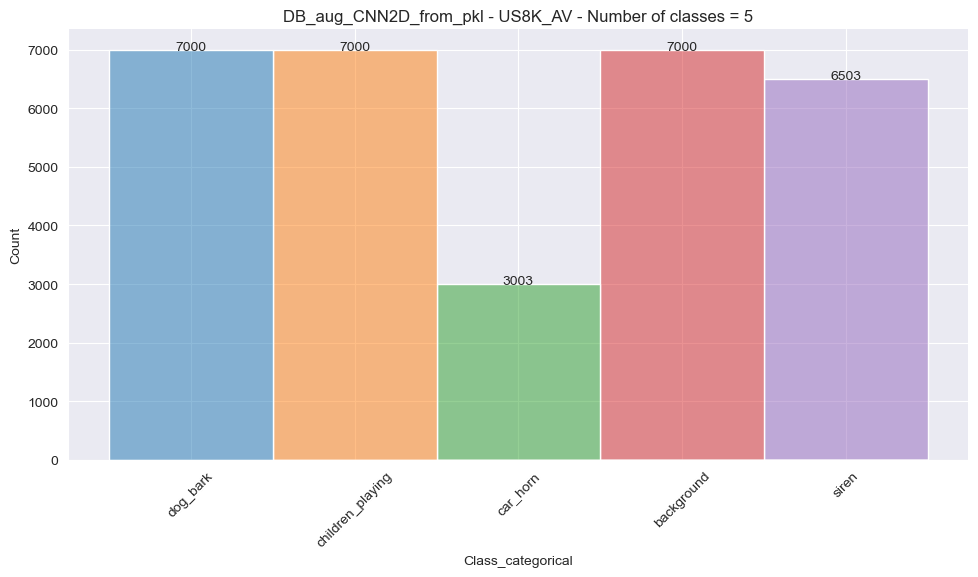

In [13]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_CNN2D_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_CNN2D_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_CNN2D_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

In [14]:
# Group by the class and get one random sample of each class
k = DB_aug_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         21120    [1, 0, 0, 0, 0]
car_horn           26717    [0, 1, 0, 0, 0]
children_playing   859      [0, 0, 1, 0, 0]
dog_bark           27962    [0, 0, 0, 1, 0]
siren              3048     [0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 1])}

In [15]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

5

In [16]:
# Name of the classes

nom_classes = list(encoder_dict.keys())

with open(os.path.join(path_arrays, 'nom_classes.csv'), 'w') as file:
    for value in nom_classes:
        file.write(value + '\n')

nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

In [17]:
# Retrieve the name of the classes

nom_classes = []
with open(os.path.join(path_arrays, 'nom_classes.csv'), 'r') as file:
    for line in file:
        nom_classes.append(line.strip())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

In [18]:
for col in DB_ori_from_pkl.columns:
    print(col)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [19]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold_name].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold_name].copy()

In [20]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_aug_from_pkl_VAL = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] == fold_name].copy()
DB_aug_from_pkl_TRN = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] != fold_name].copy()

In [21]:
print(len(DB_ori_from_pkl_VAL))
print(len(DB_ori_from_pkl_TRN))
print('Total: ', len(DB_ori_from_pkl_VAL) + len(DB_ori_from_pkl_TRN),'\n')
print(len(DB_aug_from_pkl_VAL))
print(len(DB_aug_from_pkl_TRN))
print('Total: ', len(DB_aug_from_pkl_VAL) + len(DB_aug_from_pkl_TRN))

430
3928
Total:  4358 

3010
27496
Total:  30506


In [22]:
# Separating data and labels for training
X      = DB_aug_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_cat  = np.array(DB_aug_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_aug_from_pkl_TRN.Class_OHEV.to_list())

# Separating data and labels for validation
X_val      = DB_aug_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val_cat  = np.array(DB_aug_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_aug_from_pkl_VAL.Class_OHEV.to_list())

In [23]:
type(X.at[1, 'RMSE'])

numpy.float64

In [24]:
# Select from normalization or standartization

def scaler(X: pd.DataFrame, X_val: pd.DataFrame, opc:int):
    opc = opc
    while str(opc) not in '12':
        print()
        print("1-) Normalization (Scaled from 0 to 1)")
        print("2-) Standartization (Standard deviation of 1)")

        opc = input("\nSelect the dataset: ")
        if opc.isdigit():
            opc = int(opc)
        else:
            opc = 0

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Save Min, Max, Mean and standard deviation to be used in the next notebooks

    X_mean.tofile(os.path.join(path_arrays, 'X_train_mean.csv'), sep=',')
    X_std.tofile(os.path.join(path_arrays,  'X_train_std.csv'),  sep=',')
    X_min.tofile(os.path.join(path_arrays,  'X_train_min.csv'),  sep=',')
    X_max.tofile(os.path.join(path_arrays,  'X_train_max.csv'),  sep=',')
        
    if opc == 1:
        X_train_norm = (X.values - X_min) / (X_max - X_min)
        X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
        batch_type    = '_norm'
        print(f'\nX_train_norm shape...:{X_train_norm.shape}')
        print(f'X_val_norm shape.....:{X_val_norm.shape}\n')

    elif opc == 2:
        X_train_norm = (X.values - X_mean) / X_std
        X_val_norm   = (X_val.values - X_mean) / X_std
        batch_type    = '_std'
        print(f'\nX_train_norm shape...:{X_train_norm.shape}')
        print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
    return X_train_norm, X_val_norm

In [25]:
X_norm, X_val_norm = scaler(X, X_val, 1)


X_train_norm shape...:(27496, 375)
X_val_norm shape.....:(3010, 375)



In [26]:
RMSE_lst = []
for i in X_norm:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))

0.08779795319423672


In [27]:
X_t= X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_t.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,27496.000000,27496.000000,27496.000000,27496.000000,...,27496.000000,27496.000000,27496.000000,27496.000000
mean,0.087798,0.173688,0.256450,0.378917,...,0.099956,0.395129,0.578798,0.069517
std,0.093580,0.117800,0.133928,0.139132,...,0.088276,0.067473,0.072283,0.046378
min,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,0.025530,0.101113,0.165673,0.276386,...,0.052194,0.362705,0.535161,0.042750
50%,0.056446,0.147041,0.232181,0.367313,...,0.076216,0.394680,0.577393,0.059358
75%,0.117743,0.203369,0.308281,0.467391,...,0.117657,0.427130,0.620565,0.082411
max,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000


In [28]:
X_t['RMSE'].mean()

0.08779795319423672

In [29]:
X_std, X_val_std = scaler(X, X_val, 2)


X_train_norm shape...:(27496, 375)
X_val_norm shape.....:(3010, 375)



In [30]:
RMSE_lst2 = []
for i in X_std:
    RMSE_lst2.append([i][0][0])
    
print(np.mean(RMSE_lst2))

-8.269336465057902e-18


In [31]:
X_t2= X.apply(lambda x: (x - x.mean()) / x.std())
X_t2.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,2.749600e+04,2.749600e+04,2.749600e+04,2.749600e+04,...,2.749600e+04,2.749600e+04,27496.000000,2.749600e+04
mean,-8.269336e-18,-5.788536e-17,1.488481e-16,-5.126989e-16,...,5.168335e-17,-2.144859e-17,0.000000,-1.033667e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
min,-9.382175e-01,-1.474433e+00,-1.914828e+00,-2.723426e+00,...,-1.132315e+00,-5.856130e+00,-8.007378,-1.498921e+00
25%,-6.654041e-01,-6.160890e-01,-6.778024e-01,-7.369316e-01,...,-5.410548e-01,-4.805513e-01,-0.603696,-5.771418e-01
50%,-3.350271e-01,-2.262003e-01,-1.812077e-01,-8.340514e-02,...,-2.689247e-01,-6.645925e-03,-0.019429,-2.190398e-01
75%,3.199957e-01,2.519650e-01,3.870092e-01,6.358991e-01,...,2.005251e-01,4.742897e-01,0.577832,2.780233e-01
max,9.747881e+00,7.014547e+00,5.551850e+00,4.463971e+00,...,1.019584e+01,8.964689e+00,5.827128,2.006315e+01


In [32]:
X_t2['RMSE'].mean()

-8.269336465057902e-18

In [33]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [34]:
# Plot the confusion matrix

def plot_confusion_matrix(y_test_enc, y_pred_saved, score_saved, cmap, model_name, ax=None, savepic = True):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    if type(score_saved) == list:
        score = score_saved[1]
    else:
        score = score_saved
    
    conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_saved)
    title = nom_dataset + ' - ' + model_name[:-17] + ' (best model) - Highest accuracy validation: '+ str("{:0.2f}%".format(score*100))

    if ax is None:
        plt.figure(figsize = (10,10))
        ax = plt.gca()
        
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 12}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes,
                ax=ax)
    ax.set_title(title, fontsize = 14)
    
    if savepic:
        plt.savefig(os.path.join(path_pic, picture_name))

In [35]:
print(X_std.shape)
print(y_OHEV.shape)
print(y_cat.shape)
print("=====================")
print(X_val_std.shape)
print(y_OHEV_val.shape)
print(y_val_cat.shape)

(27496, 375)
(27496, 5)
(27496,)
(3010, 375)
(3010, 5)
(3010,)


In [36]:
print(X_norm.shape)
print(y_OHEV.shape)
print(y_cat.shape)
print("=====================")
print(X_val_norm.shape)
print(y_OHEV_val.shape)
print(y_val_cat.shape)

(27496, 375)
(27496, 5)
(27496,)
(3010, 375)
(3010, 5)
(3010,)


In [37]:
# Retrieve the indexes used for training the classifiers in the notebook 04_ML_modeling.ipynb

idx_trn = np.genfromtxt(os.path.join(path_models,  '_idx_trn_US8K_AV_windowed.csv'), delimiter=',', dtype = int)
idx_tst = np.genfromtxt(os.path.join(path_models,  '_idx_tst_US8K_AV_windowed.csv'), delimiter=',', dtype = int)

In [38]:
idx_trn

array([ 5221, 26886, 26007, ...,  1207, 16801, 16613])

In [39]:
idx_tst

array([12980,  2697, 15451, ...,  5356, 21051, 12598])

In [40]:
X_train     = X_norm[idx_trn]
X_test      = X_norm[idx_tst]
X_trainS    = X_std[idx_trn]
X_testS     = X_std[idx_tst]
y_train     = y_OHEV[idx_trn]
y_test      = y_OHEV[idx_tst]
y_train_cat = y_cat[idx_trn]
y_test_cat  = y_cat[idx_tst]

In [41]:
print(f'Training data norm.....: {X_train.shape}')
print(f'Training data std......: {X_trainS.shape}')
print(f'Training label.........: {y_train.shape}')
print(f'Training label catg....: {y_train_cat.shape}')
print("========================================")
print(f'Testing data norm......: {X_test.shape}')
print(f'Testing data std.......: {X_testS.shape}')
print(f'Testing label..........: {y_test.shape}')
print(f'Testing label catg.....: {y_test_cat.shape}')
print("========================================")
print(f'Validation data norm...: {X_val_norm.shape}')
print(f'Validation data std....: {X_val_std.shape}')
print(f'Validation label.......: {y_OHEV_val.shape}')
print(f'Validation label catg..: {y_val_cat.shape}')
print("========================================")


Training data norm.....: (24746, 375)
Training data std......: (24746, 375)
Training label.........: (24746, 5)
Training label catg....: (24746,)
Testing data norm......: (2750, 375)
Testing data std.......: (2750, 375)
Testing label..........: (2750, 5)
Testing label catg.....: (2750,)
Validation data norm...: (3010, 375)
Validation data std....: (3010, 375)
Validation label.......: (3010, 5)
Validation label catg..: (3010,)


In [42]:
# For OHEV

Counter_test     = Counter(map(tuple, y_test))
Counter_test_cat = Counter(y_test_cat)
Counter_train    = Counter(map(tuple, y_train))

In [43]:
print('Training samples')
Counter_train

Training samples


Counter({(0, 0, 0, 0, 1): 5311,
         (0, 0, 0, 1, 0): 5670,
         (0, 1, 0, 0, 0): 2476,
         (0, 0, 1, 0, 0): 5670,
         (1, 0, 0, 0, 0): 5619})

In [44]:
print('Testing samples')
Counter_test

Testing samples


Counter({(1, 0, 0, 0, 0): 625,
         (0, 0, 0, 1, 0): 630,
         (0, 1, 0, 0, 0): 275,
         (0, 0, 1, 0, 0): 630,
         (0, 0, 0, 0, 1): 590})

In [45]:
print('Testing samples')
Counter_test_cat

Testing samples


Counter({'background': 625,
         'dog_bark': 630,
         'car_horn': 275,
         'children_playing': 630,
         'siren': 590})

In [46]:
n_dim = X_train.shape[1]
n_dim

375

In [47]:
# Separate 1 fold for validation and create a DB for the training / testing CNN2D

DB_aug_from_pkl_VAL_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] == fold_name].copy()
DB_aug_from_pkl_TRN_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] != fold_name].copy()

In [48]:
print(f'dbComplete_VAL size..: {str(len(DB_aug_from_pkl_VAL_CNN2D))}')
print(f'dbComplete size......: {str(len(DB_aug_from_pkl_TRN_CNN2D))}')

dbComplete_VAL size..: 3010
dbComplete size......: 27496


In [49]:
X_val_CNN2D   = DB_aug_from_pkl_VAL_CNN2D['features'].to_numpy()
y_val_CNN2D   = np.array(DB_aug_from_pkl_VAL_CNN2D.Class_OHEV.to_list())
X_train_CNN2D = DB_aug_from_pkl_TRN_CNN2D['features'].to_numpy()
y_train_CNN2D = np.array(DB_aug_from_pkl_TRN_CNN2D.Class_OHEV.to_list())
print(f'X_train antes do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train antes do stack..: {X_train_CNN2D.shape}')

X_train antes do stack...........: 27496
Shape do X_train antes do stack..: (27496,)


In [50]:
X_val_CNN2D   = np.stack(X_val_CNN2D)
X_train_CNN2D = np.stack(X_train_CNN2D)

In [51]:
print(f'X_train depis do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train depois do stack..: {X_train_CNN2D.shape}')

X_train depis do stack...........: 27496
Shape do X_train depois do stack..: (27496, 180, 44, 1)


In [52]:
# Passing all elements as float32
X_train_CNN2D = np.asarray(X_train_CNN2D).astype(np.float32)
y_train_CNN2D = np.asarray(y_train_CNN2D).astype(np.float32)
X_val_CNN2D   = np.asarray(X_val_CNN2D).astype(np.float32)
y_val_CNN2D   = np.asarray(y_val_CNN2D).astype(np.float32)

In [53]:
X_train_CNN2D_final = X_train_CNN2D[idx_trn]
X_test_CNN2D        = X_train_CNN2D[idx_tst]
y_train_CNN2D_final = y_train_CNN2D[idx_trn]
y_test_CNN2D        = y_train_CNN2D[idx_tst]

In [54]:
print(f'X_train_CNN2D_final shape..: {np.shape(X_train_CNN2D_final)}')
print(f'y_train_CNN2D_final shape..: {np.shape(y_train_CNN2D_final)}')
print(f'X_test_CNN2D shape.........: {np.shape(X_test_CNN2D)}')
print(f'y_test_CNN2D shape.........: {np.shape(y_test_CNN2D)}')
print(f'X_val_CNN2D shape..........: {np.shape(X_val_CNN2D)}')
print(f'y_val_CNN2D shape..........: {np.shape(y_val_CNN2D)}')

X_train_CNN2D_final shape..: (24746, 180, 44, 1)
y_train_CNN2D_final shape..: (24746, 5)
X_test_CNN2D shape.........: (2750, 180, 44, 1)
y_test_CNN2D shape.........: (2750, 5)
X_val_CNN2D shape..........: (3010, 180, 44, 1)
y_val_CNN2D shape..........: (3010, 5)


### BEFORE STARTING

To avoid misuse of the previous saved models, before starting, copy the following files used for training the classifiers considering the fold 1 as the validation set to the folder:

**_ESR\Saved_models_fold_1_validation**

* Model_ANN_weights_0_best_norm_windowed.hdf5
* Model_CNN_1D_weights_0_best_norm_windowed.hdf5
* Model_CNN_2D_weights_0_best_windowed.hdf5
* Model_Forest_norm_windowed.pkl
* Model_LogisticR_norm_windowed.pkl
* Model_SVC_norm_windowed.pkl

### Train / Test / Validation sets according classifiers

The train / test split was carried out to confirm the results from the previous notebook. For simplicity, this checking was omitted in this notebook and only the validation sets were explicitly confirmed.

**MLP, CNN1D**
   
* X_trainN    
* X_testN  
* y_train     
* y_test
* X_val_norm
* y_val

**LR, SVC, RF**

* X_trainN    
* X_testN  
* y_train_cat 
* y_test_cat 
* X_val_norm
* y_val_cat

**CNN2D**

* X_train_CNN2D_final
* X_test_CNN2D
* y_train_CNN2D_final 
* y_test_CNN2D
* X_val_CNN2D
* y_val_CNN2D

## Partial conclusion presented in the qualification exam

* Despite not being the main focus of this study, in at least one of the proposed models, the accuracy surpassed the benchmark of the selected datasets;

* The custom dataset US8K_AV achieved an average accuracy of 81% to 82% using LR, MLP and 1D CNN;

* Principal Component Analysis (PCA) resulted in an average reduction of 50% or more in the number of attributes without significantly affecting the accuracy of the classifiers;

* The inclusion of Mutual Information resulted in a significant increase in the accuracy of the Random Forest classifier, additionally there was an average reduction of 50% in the number of attributes and therefore this classifier will continue to be analyzed in the next stages;

* In light of the advantages derived from the 1-second response time, the utilization of the window technique has demonstrated a constrained impact on accuracy and will be the established as the only technique to continue to be investigated.

### Models to be investigated (for training: all windowed)

* LR - Logistic Regression with **standardized** (Accuracy: 80.43% +/- 2.54%). 
    * Best folds 2, 1, 10, 8.
* RF - Random Forest with **un-normalized Mutual Information** (Accuracy 80.50% +/-3.28%). Non-windowed validation set. 
    * Best folds 1, 6, 2, 3.
* MLP - Multilayer Perceptron with **standardized** (Accuracy: 81.24% +/-2.96%). 
    * Best folds 9, 3, 1, 5.
* CNN_1D - Convolution Neural Network 1D with **standardized** (Accuracy: 80.44% +/- 3.58%). 
    * Best folds 9, 1, 8, 5.
* CNN_2D - Convolution Neural Network 2D **Log-Mel agg with delta** (Accuracy: 80.76% +/- 2.59%). 
    * Best folds 3, 9, 1, 6.

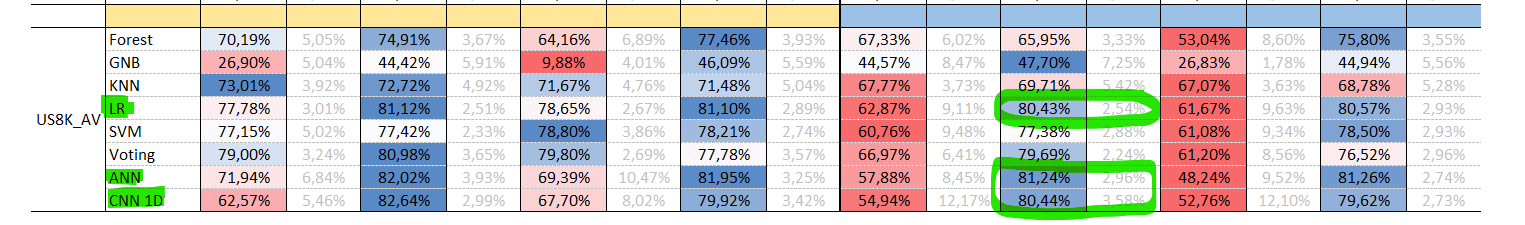

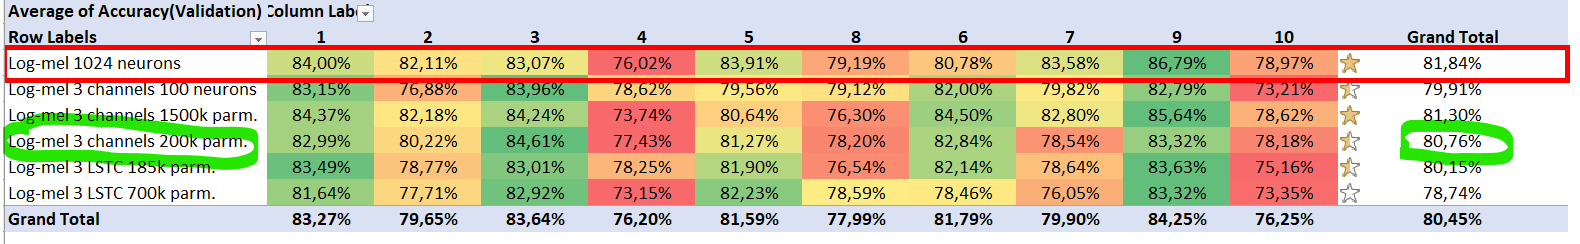

The "Log-mel 1024 neurons" and "Log-mel 3 channels 1500h param." models wer not choosen give its huge numbers of parameters (15.5M and 1.5M respectively). The third best model was defined instead as a compromise between accuracy and size.

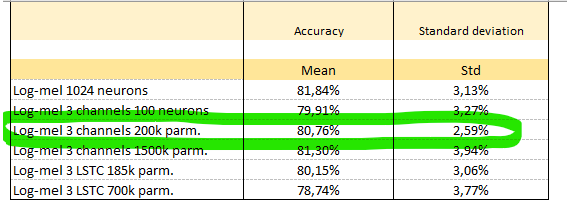


***
For the next steps, the fold 1 will be chosen as the validation set given it's presence in all selected classifiers.

* Fold 1 samples (validation): 2,968
* Training samples: 27,538 (24,784 training / 2,754 testing)
* Total:  30,506

***

## Checking the results with the classifiers saved models

### SVC - Expected results for fold 1 validation: 81.36% 

### SVC - Expected results for fold 1 validation based on k-fold cross-validation: 81.83% 

Images from the file: 04_ML_modeling.ipynb

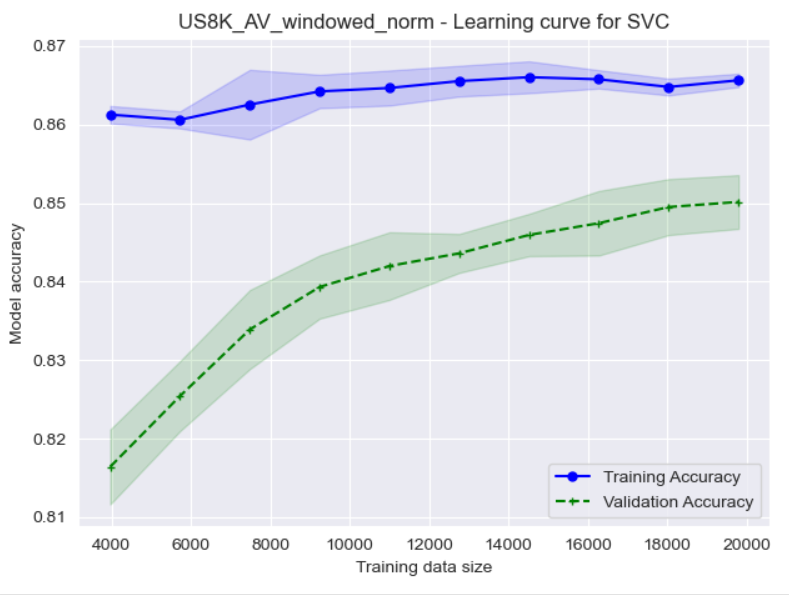
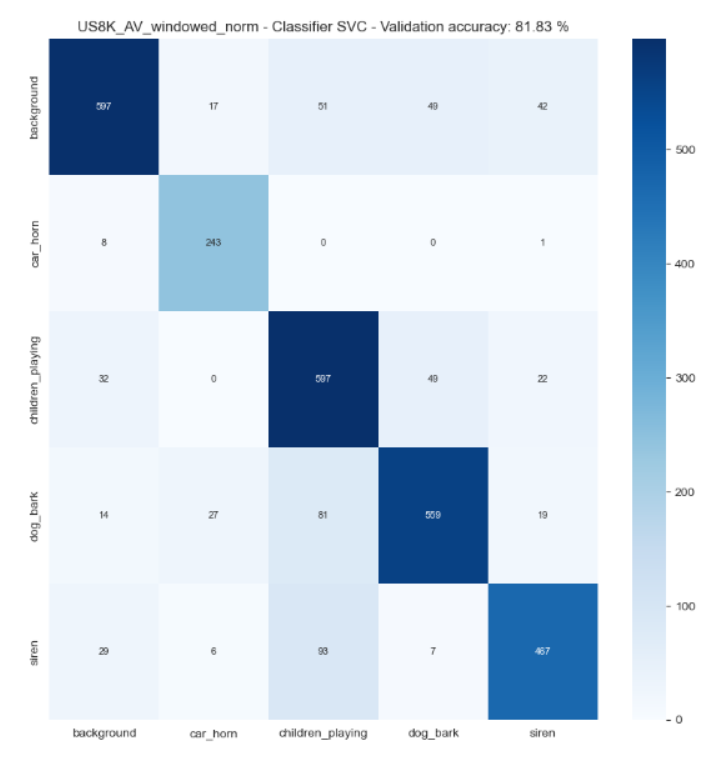

In [55]:
# Load the classifier from file

with open(os.path.join(path_modelsVal, 'Model_SVC_norm_windowed.pkl'), 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [56]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))

Test score (R2): 81.83 %


In [57]:
score_SVC_c_saved

0.8182724252491694

In [58]:
t_srt                   = time.perf_counter_ns()
SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
t_end                   = time.perf_counter_ns()
proc_time               = ((t_end - t_srt) / 1000000)

print(SVC_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'car_horn' 'car_horn' 'car_horn']

Number of predicted samples..: 3010
Total predicting time:.......: 6088.6701ms
Predicting time per sample...: 2.022814ms


In [59]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.88      0.79      0.83       756
        car_horn       0.83      0.96      0.89       252
children_playing       0.73      0.85      0.78       700
        dog_bark       0.84      0.80      0.82       700
           siren       0.85      0.78      0.81       602

        accuracy                           0.82      3010
       macro avg       0.82      0.84      0.83      3010
    weighted avg       0.82      0.82      0.82      3010



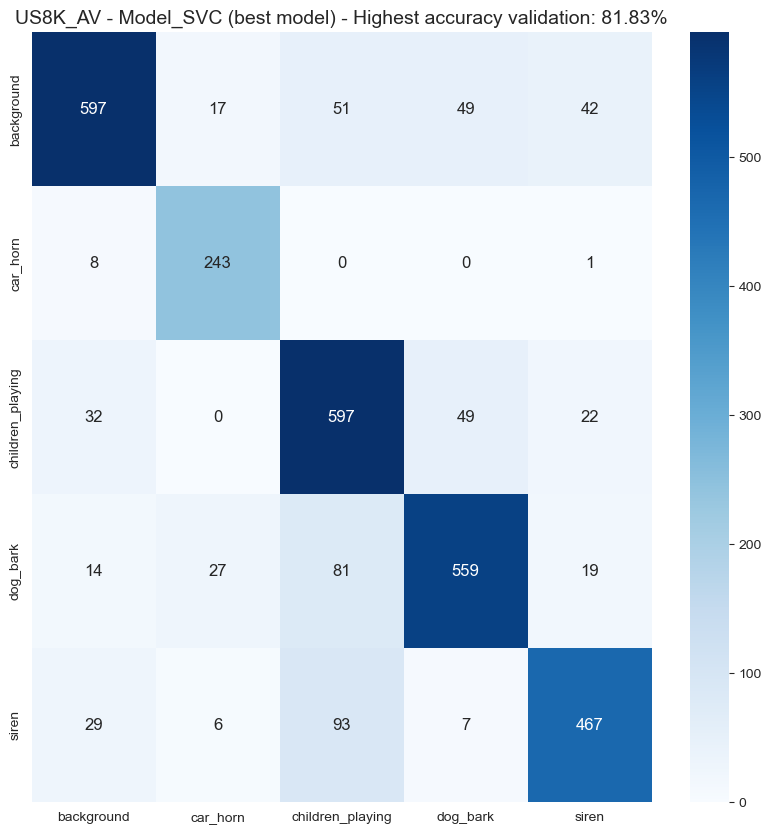

In [60]:
plot_confusion_matrix(y_val_cat, 
                      SVC_c_saved_predict_val, 
                      score_SVC_c_saved, 
                      cmap_cm, 
                      'Model_SVC_confusion_matrix',
                      ax = None,
                      savepic = False)

### LR - Expected results for fold 1 validation: 81.89% 

### LR - Expected results for fold 1 validation based on k-fold cross-validation: 81.99% 

Images from the file: 04_ML_modeling.ipynb

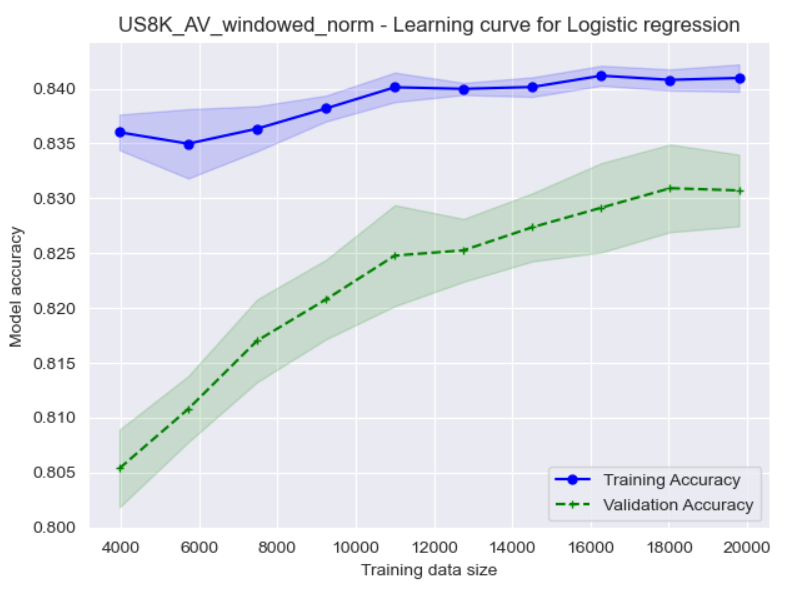
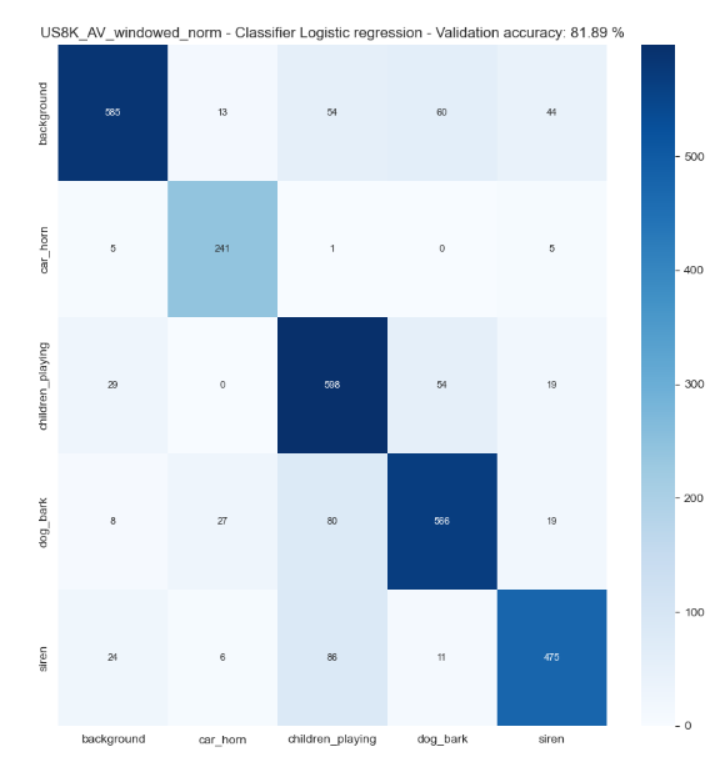

In [61]:
# Load the classifier from file

with open(os.path.join(path_modelsVal, 'Model_LogisticR_norm_windowed.pkl'), 'rb') as file:
    LR_c_saved = pickle.load(file)

In [62]:
score_LR_c_saved = LR_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_LR_c_saved))

Test score (R2): 81.89 %


In [63]:
score_LR_c_saved

0.8189368770764119

In [64]:
t_srt                  = time.perf_counter_ns()
LR_c_saved_predict_val = LR_c_saved.predict(X_val_norm)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(LR_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'car_horn' 'car_horn' 'car_horn']

Number of predicted samples..: 3010
Total predicting time:.......: 3.5681ms
Predicting time per sample...: 0.001185ms


In [65]:
for i in LR_c_saved_predict_val:
    print(i)

dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
background
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
children_playing
dog_bark
children_playing
children_playing
dog_bark
children_playing
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background

In [66]:
LR_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            LR_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(LR_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.90      0.77      0.83       756
        car_horn       0.84      0.96      0.89       252
children_playing       0.73      0.85      0.79       700
        dog_bark       0.82      0.81      0.81       700
           siren       0.85      0.79      0.82       602

        accuracy                           0.82      3010
       macro avg       0.83      0.84      0.83      3010
    weighted avg       0.83      0.82      0.82      3010



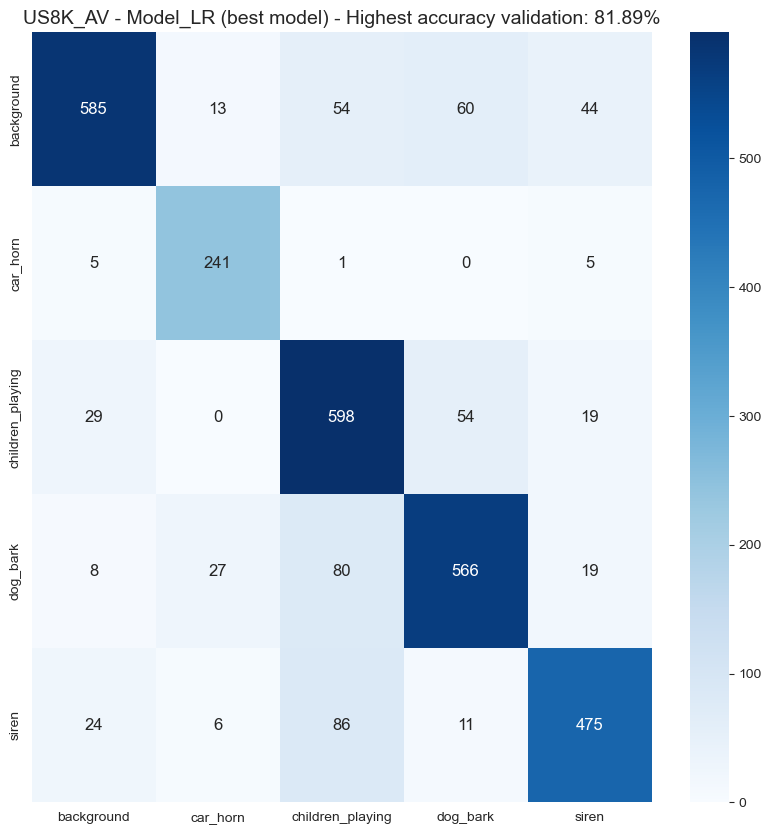

In [67]:
plot_confusion_matrix(y_val_cat, 
                      LR_c_saved_predict_val, 
                      score_LR_c_saved, 
                      cmap_cm, 
                      'Model_LR_confusion_matrix',
                      ax = None,
                      savepic = False)

### RF - Expected results for fold 1 validation: 80.56% 

### RF - Expected results for fold 1 validation based on k-fold cross-validation: 80.10% 

Images from the file: 04_ML_modeling.ipynb

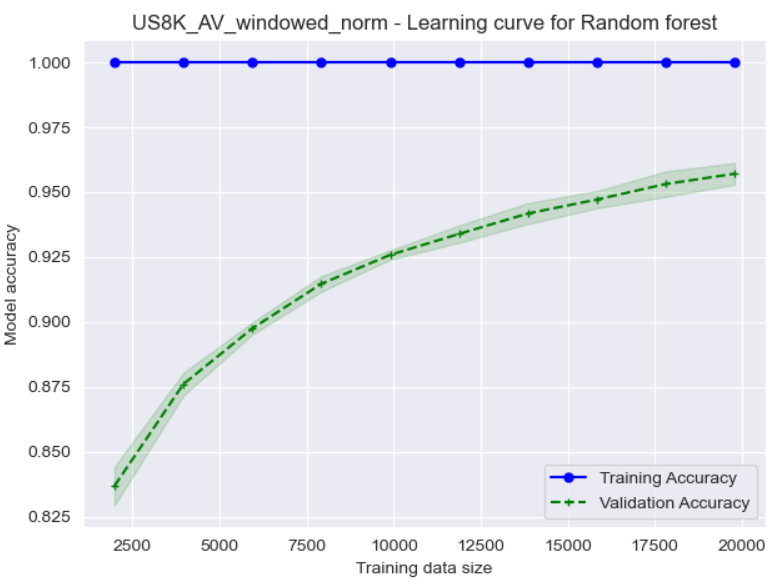
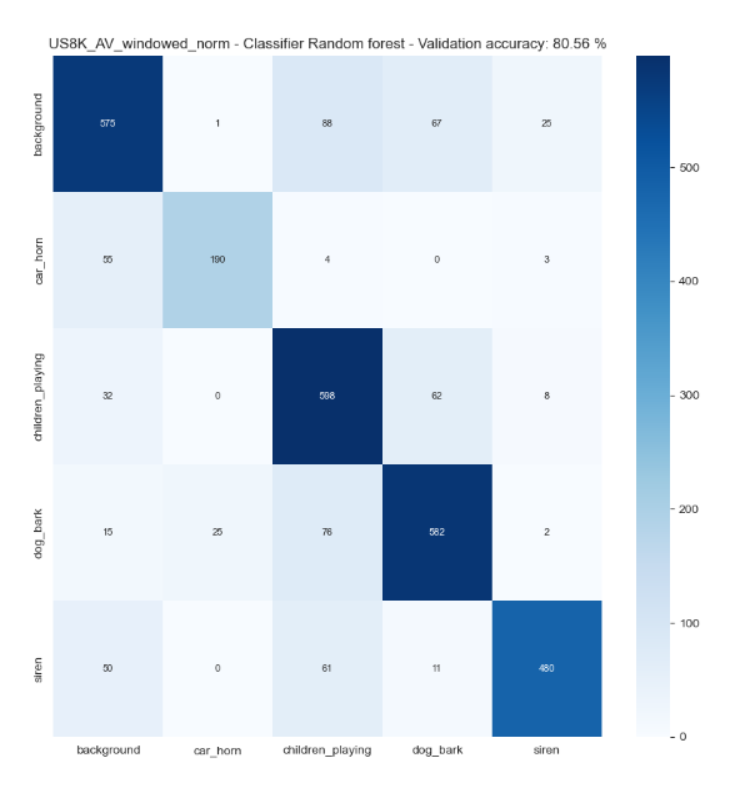

In [68]:
# Load the classifier from file

with open(os.path.join(path_modelsVal,  'Model_Forest_norm_windowed.pkl'), 'rb') as file:
    RF_c_saved = pickle.load(file)

In [69]:
score_RF_c_saved = RF_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_RF_c_saved))

Test score (R2): 80.56 %


In [70]:
score_RF_c_saved

0.8056478405315615

In [71]:
t_srt                  = time.perf_counter_ns()
RF_c_saved_predict_val = RF_c_saved.predict(X_val_norm)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(RF_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'background' 'background'
 'background']

Number of predicted samples..: 3010
Total predicting time:.......: 144.1858ms
Predicting time per sample...: 0.047902ms


In [72]:
RF_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            RF_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(RF_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.79      0.76      0.78       756
        car_horn       0.88      0.75      0.81       252
children_playing       0.72      0.85      0.78       700
        dog_bark       0.81      0.83      0.82       700
           siren       0.93      0.80      0.86       602

        accuracy                           0.81      3010
       macro avg       0.83      0.80      0.81      3010
    weighted avg       0.81      0.81      0.81      3010



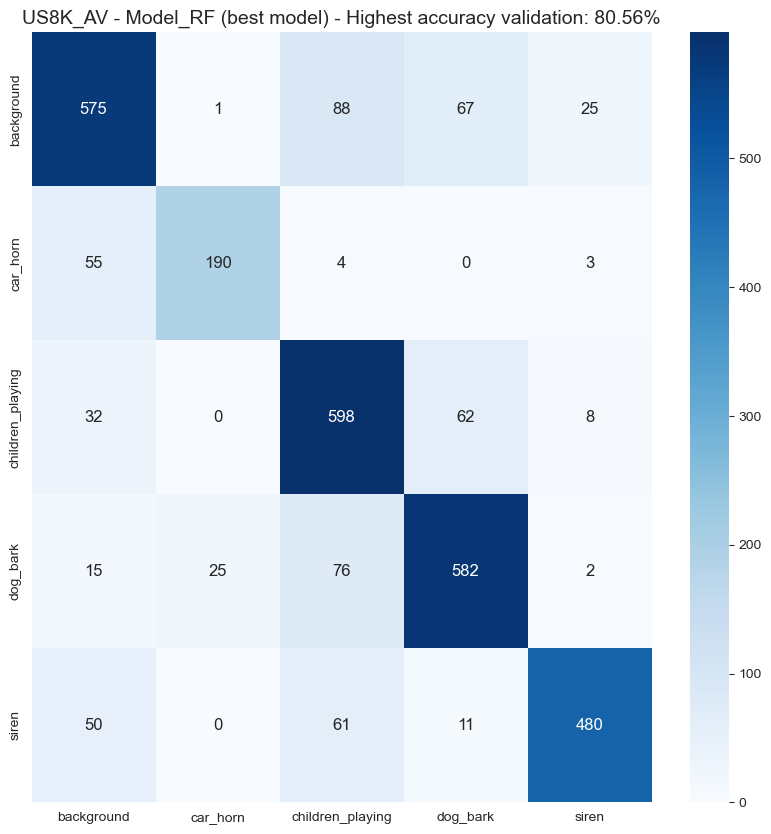

In [73]:
plot_confusion_matrix(y_val_cat, 
                      RF_c_saved_predict_val, 
                      score_RF_c_saved, 
                      cmap_cm, 
                      'Model_RF_confusion_matrix',
                      ax = None,
                      savepic = False)

### MLP - Expected results for fold 1 validation: 82.19% 

### MLP - Expected results for fold 1 validation based on k-fold cross-validation: 80.73% 

Images from the file: 04_ML_modeling.ipynb

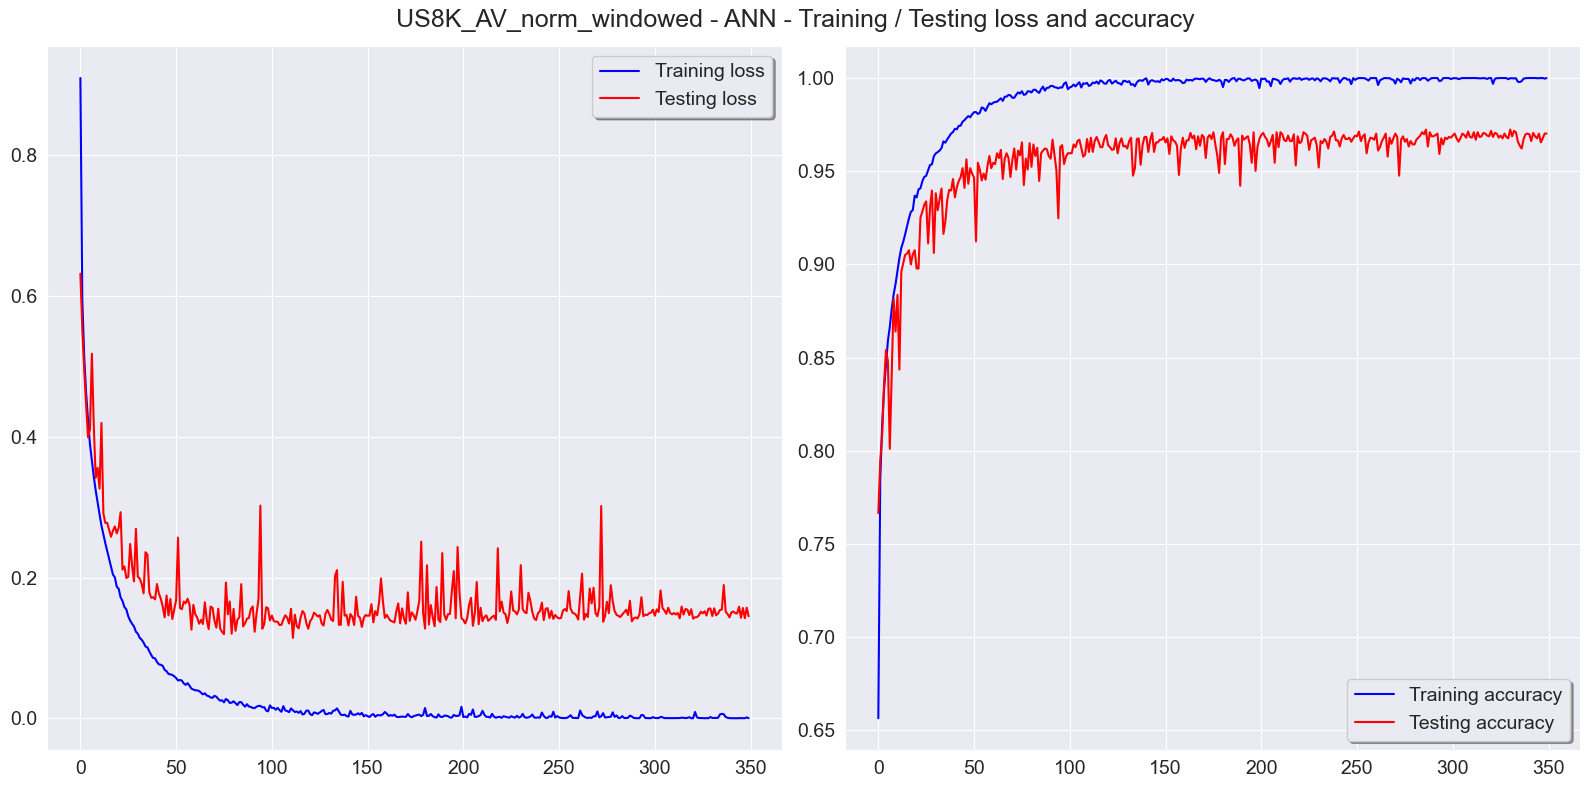
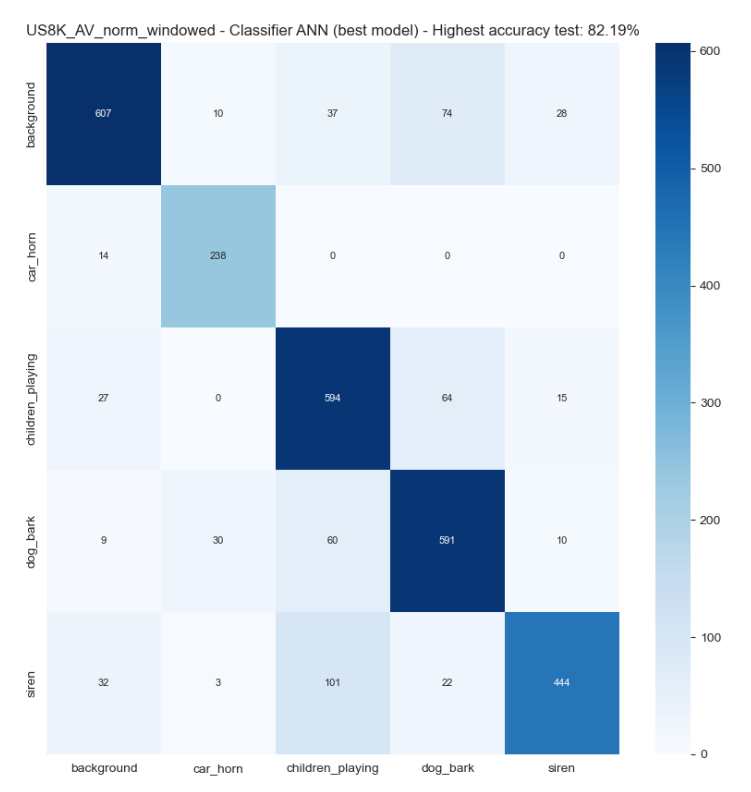

In [74]:
# Load the model with the highest accuracy

model_ANN_saved = load_model(os.path.join(path_modelsVal,  'Model_ANN_weights_0_best_norm_windowed.hdf5'))
model_ANN_saved.summary()

Model: "ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 375)               141000    
_________________________________________________________________
Hiden_1 (Dense)              (None, 375)               141000    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 375)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               282000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 3755      
Total params: 567,755
Trainable params: 567,755
Non-trainable params: 0
_______________________________________________________

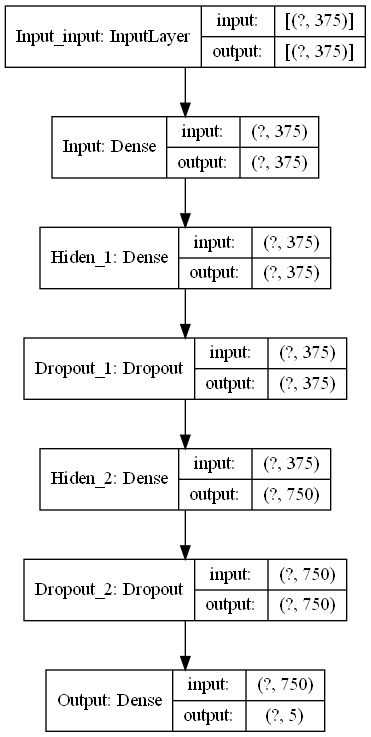

In [75]:
tf.keras.utils.plot_model(model_ANN_saved,  show_shapes=True)

In [76]:
score_ANN_saved = model_ANN_saved.evaluate(X_val_norm, y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_ANN_saved[0])
print('Test accuracy:', score_ANN_saved[1])

95/95 [==============================] - 0s 1ms/step - loss: 2.5394 - accuracy: 0.8219
Test loss: 2.539357900619507
Test accuracy: 0.8219268918037415


In [77]:
score_ANN_saved[1]

0.8219268918037415

In [78]:
t_srt            = time.perf_counter_ns()
y_pred_ANN_saved = np.argmax(model_ANN_saved.predict(X_val_norm),axis=1)
t_end            = time.perf_counter_ns()
proc_time        = ((t_end - t_srt) / 1000000)

print(y_pred_ANN_saved)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

[3 3 3 ... 0 0 0]

Number of predicted samples..: 3010
Total predicting time:.......: 120.0183ms
Predicting time per sample...: 0.039873ms


In [79]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [80]:
metrics_set_ANN = classification_report(y_test_enc, y_pred_ANN_saved, target_names=nom_classes)
print(metrics_set_ANN)

                  precision    recall  f1-score   support

      background       0.88      0.80      0.84       756
        car_horn       0.85      0.94      0.89       252
children_playing       0.75      0.85      0.80       700
        dog_bark       0.79      0.84      0.81       700
           siren       0.89      0.74      0.81       602

        accuracy                           0.82      3010
       macro avg       0.83      0.84      0.83      3010
    weighted avg       0.83      0.82      0.82      3010



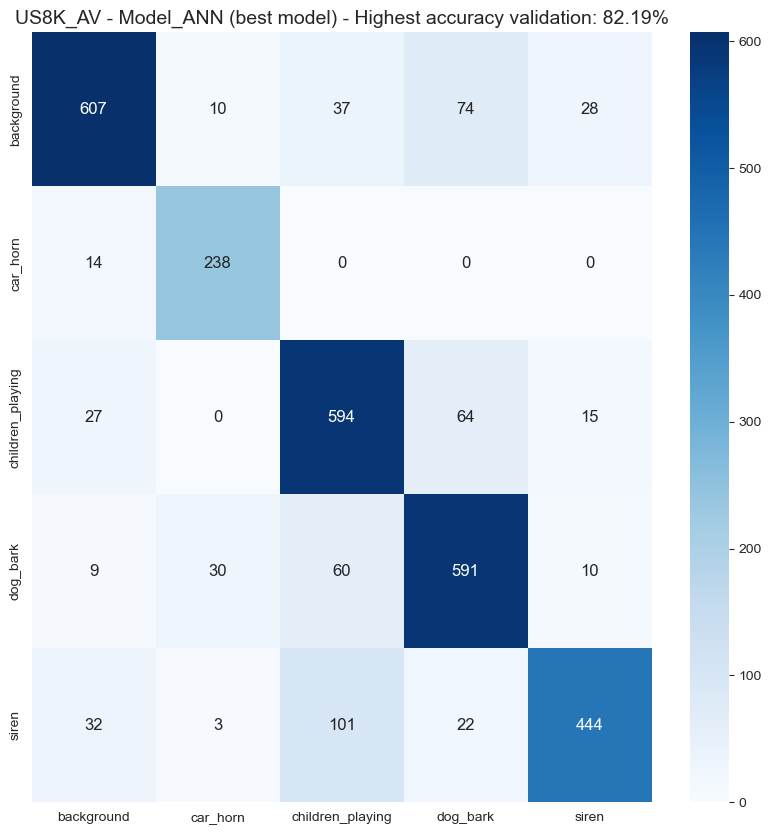

In [81]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_ANN_saved, 
                      score_ANN_saved, 
                      cmap_cm, 
                      'Model_ANN_confusion_matrix',
                      ax = None,
                      savepic = False)

### CNN 1D - Expected results for fold 1 validation: 77.51% 

### CNN 1D - Expected results for fold 1 validation based on k-fold cross-validation: 79.24% 

Images from the file: 04_ML_modeling.ipynb

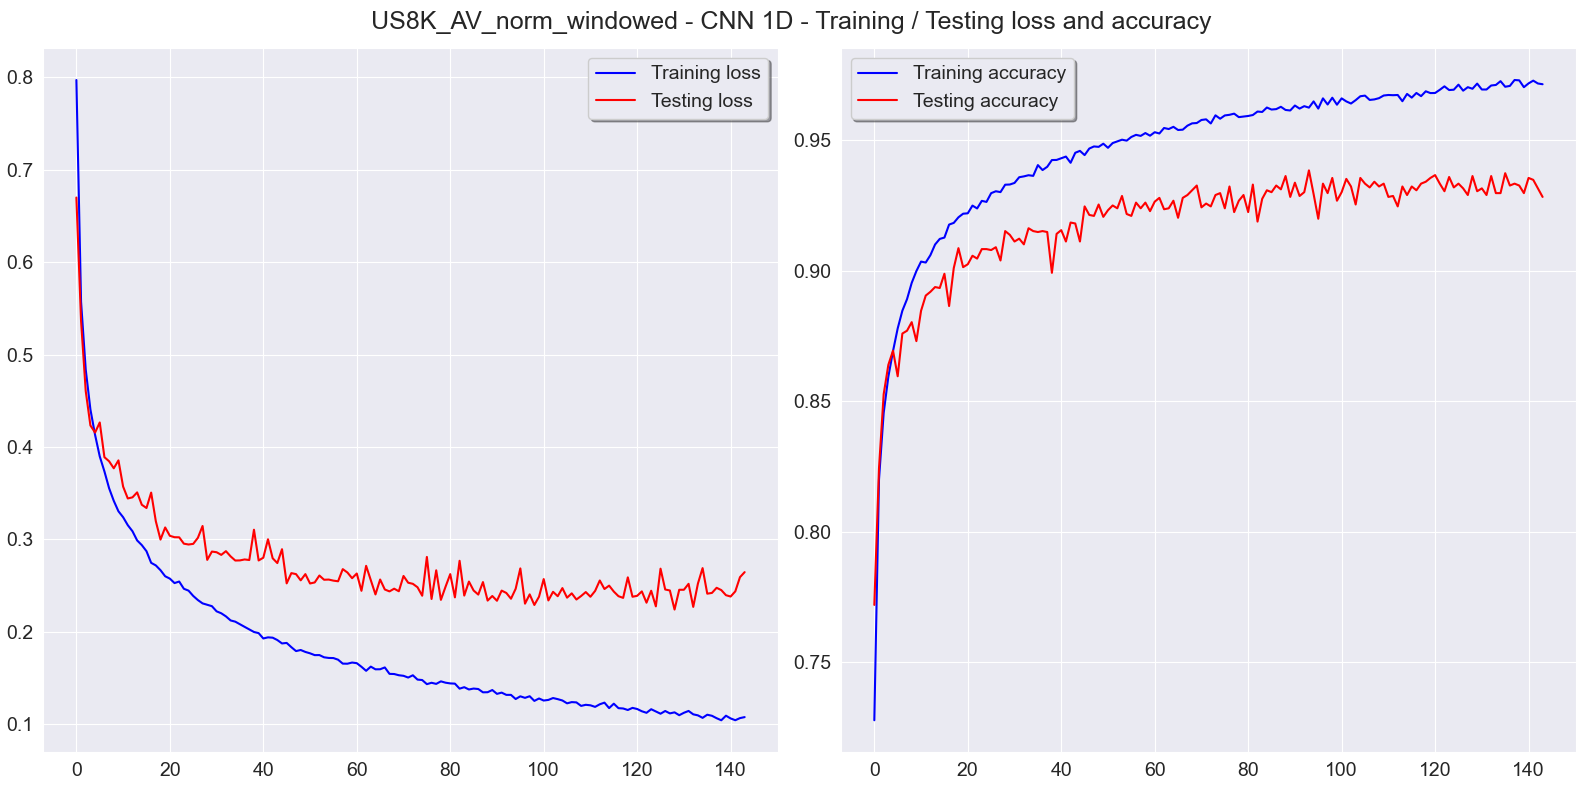
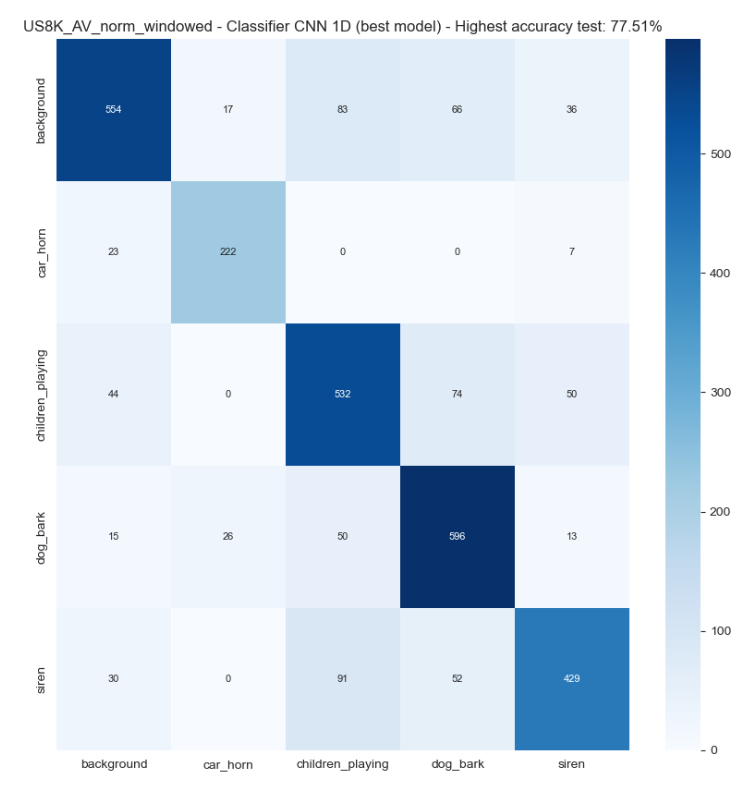

In [82]:
# Load the model with the highest accuracy

model_CNN_1D_saved = load_model(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.hdf5'))
model_CNN_1D_saved.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 369, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 369, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 369, 56)           5768      
_________________________________________________________________
MaxPool1D_3 (MaxPooling1D)   (None, 184, 56)           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 184, 56)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10304)             0         
_________________________________________________________________
Dense (Dense)                (None, 50)                51525

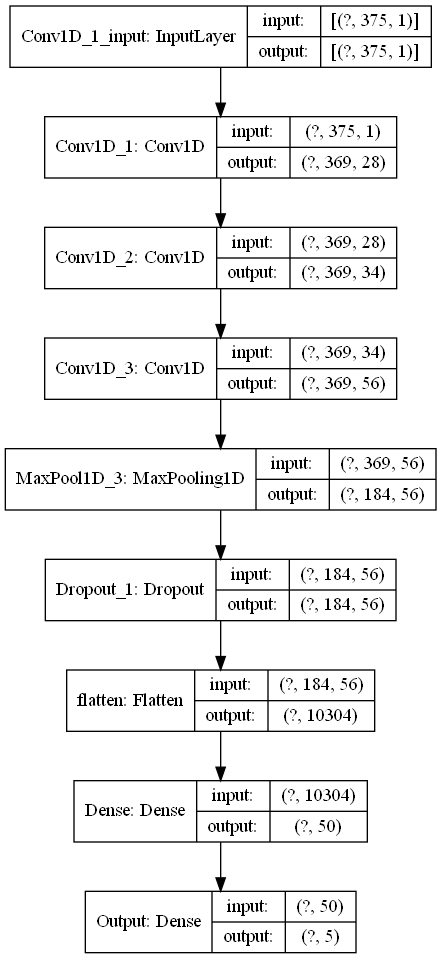

In [83]:
tf.keras.utils.plot_model(model_CNN_1D_saved,  show_shapes=True)

In [84]:
score_CNN_1D_saved = model_CNN_1D_saved.evaluate(X_val_norm[..., np.newaxis], y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_1D_saved[0])
print('Test accuracy:', score_CNN_1D_saved[1])

95/95 [==============================] - 0s 3ms/step - loss: 1.7807 - accuracy: 0.7751
Test loss: 1.7807343006134033
Test accuracy: 0.775083065032959


In [85]:
score_CNN_1D_saved[1]

0.775083065032959

In [86]:
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [87]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_1D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

[3 3 3 ... 0 0 0]

Number of predicted samples..: 3010
Total predicting time:.......: 123.3735ms
Predicting time per sample...: 0.040988ms


In [88]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [89]:
metrics_set_CNN_1D_saved = classification_report(y_test_enc, y_pred_CNN_1D_saved, target_names=nom_classes)
print(metrics_set_CNN_1D_saved)

                  precision    recall  f1-score   support

      background       0.83      0.73      0.78       756
        car_horn       0.84      0.88      0.86       252
children_playing       0.70      0.76      0.73       700
        dog_bark       0.76      0.85      0.80       700
           siren       0.80      0.71      0.75       602

        accuracy                           0.78      3010
       macro avg       0.79      0.79      0.78      3010
    weighted avg       0.78      0.78      0.77      3010



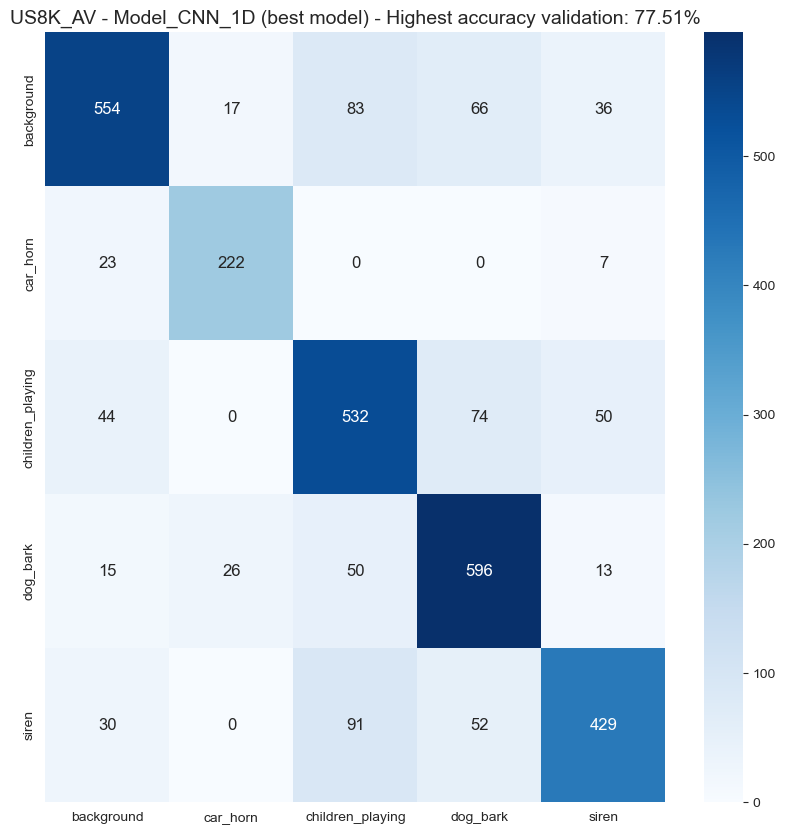

In [90]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_1D_saved, 
                      score_CNN_1D_saved, 
                      cmap_cm, 
                      'Model_CNN_1D_confusion_matrix',
                      ax = None,
                      savepic = False)

### CNN 2D - Expected results for fold 1 validation: 82.99% 

### CNN 2D - Expected results for fold 1 validation based on k-fold cross-validation: 82.43% 

Images from the file: 09_CNN_2D.ipynb

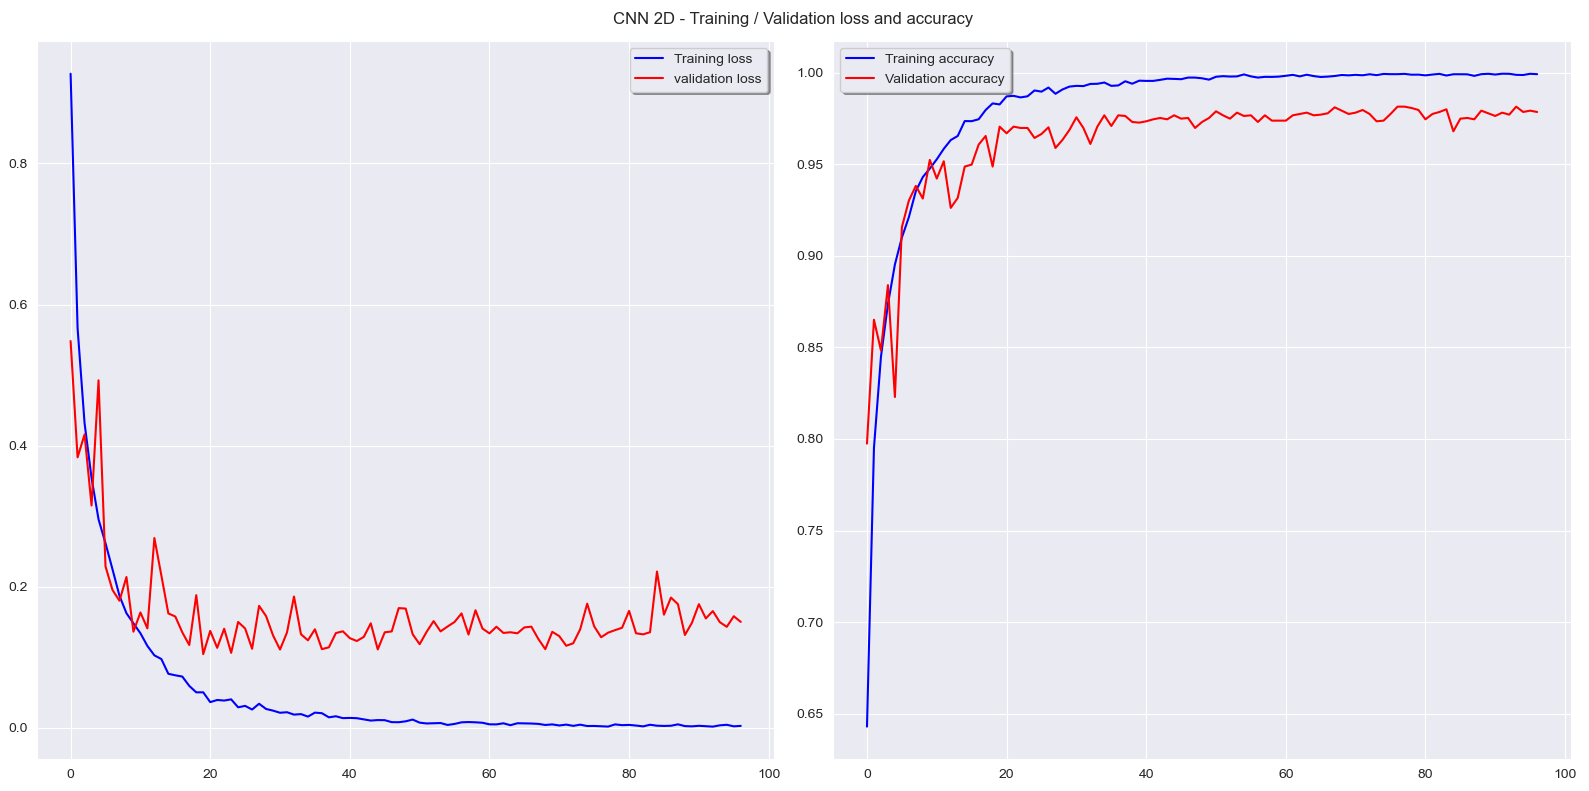
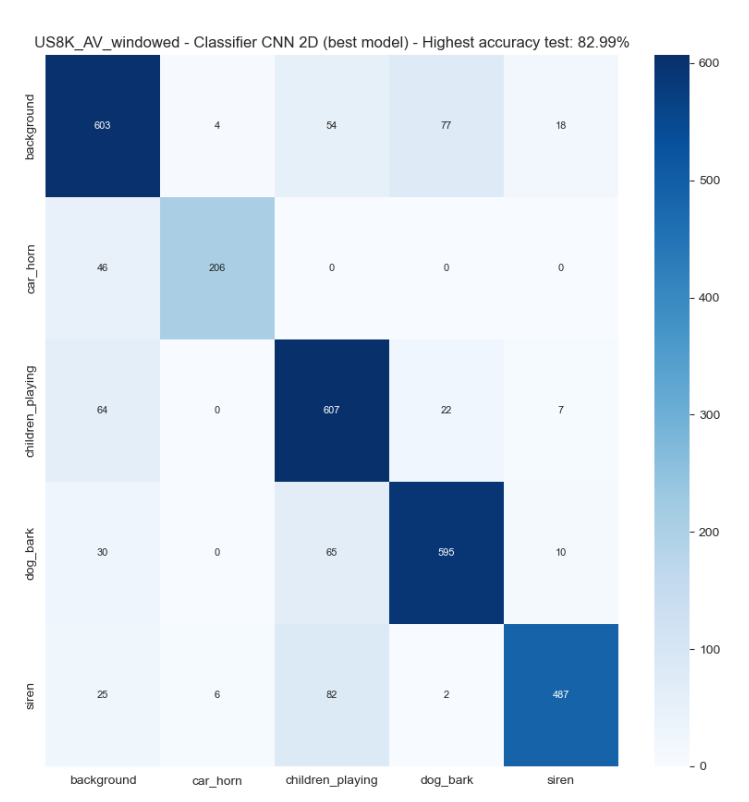

In [91]:
# Load the model with the highest accuracy

model_CNN_2D_saved = load_model(os.path.join(path_modelsVal,  'Model_CNN_2D_weights_0_best_windowed.hdf5'))
model_CNN_2D_saved.summary()

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 44, 24)       96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 22, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 22, 48)        28848     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 22, 48)        192       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 11, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 11, 48)   

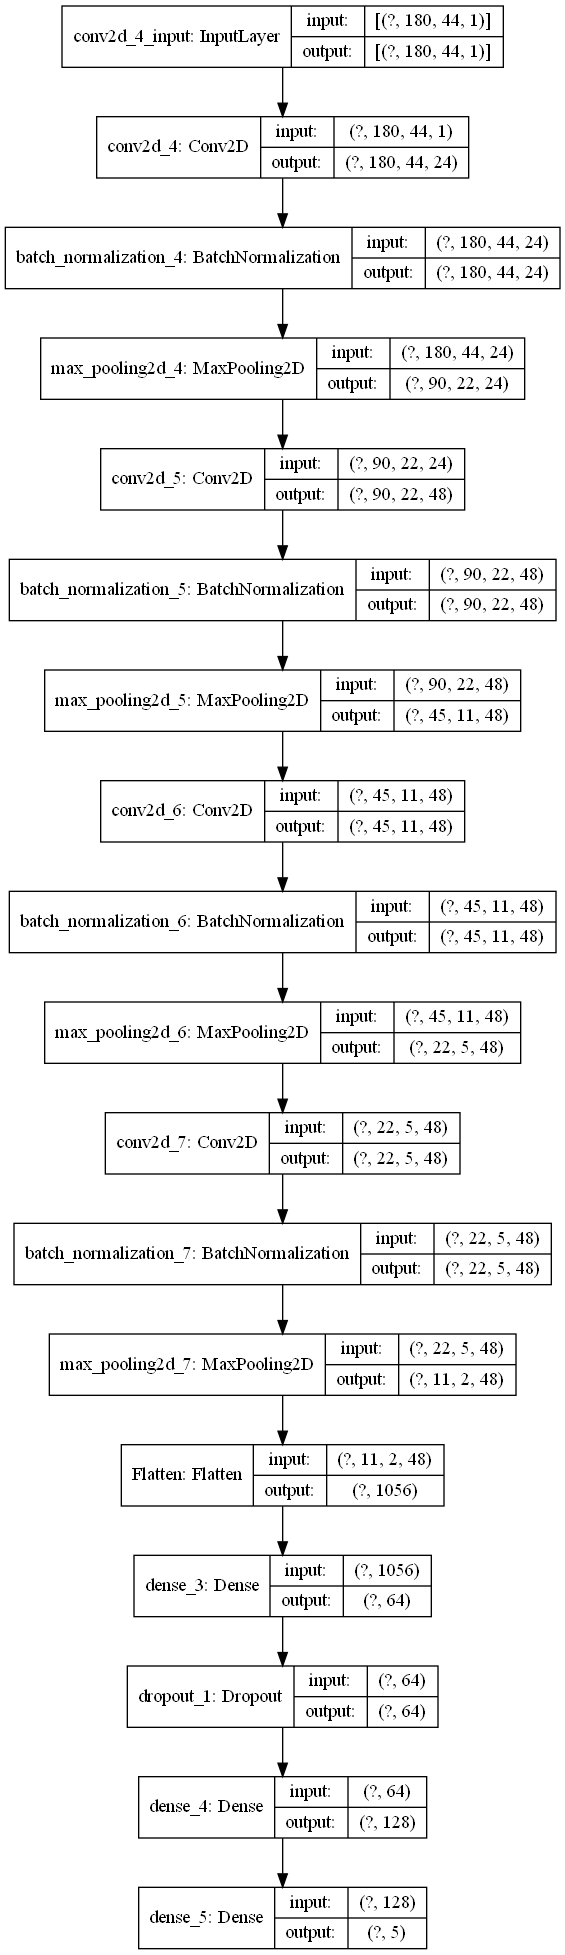

In [92]:
tf.keras.utils.plot_model(model_CNN_2D_saved,  show_shapes=True)

In [93]:
score_CNN_2D_saved = model_CNN_2D_saved.evaluate(X_val_CNN2D, y_val_CNN2D, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

95/95 [==============================] - 1s 7ms/step - loss: 1.6384 - accuracy: 0.8299
Test loss: 1.6384164094924927
Test accuracy: 0.829900324344635


In [94]:
score_CNN_2D_saved[1]

0.829900324344635

In [95]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_2D_saved = np.argmax(model_CNN_2D_saved.predict(X_val_CNN2D),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_2D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_CNN2D)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_CNN2D),6)}ms')

[3 3 3 ... 0 0 0]

Number of predicted samples..: 3010
Total predicting time:.......: 522.5652ms
Predicting time per sample...: 0.17361ms


In [96]:
y_test_enc = np.argmax(y_val_CNN2D, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [97]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.79      0.80      0.79       756
        car_horn       0.95      0.82      0.88       252
children_playing       0.75      0.87      0.81       700
        dog_bark       0.85      0.85      0.85       700
           siren       0.93      0.81      0.87       602

        accuracy                           0.83      3010
       macro avg       0.86      0.83      0.84      3010
    weighted avg       0.84      0.83      0.83      3010



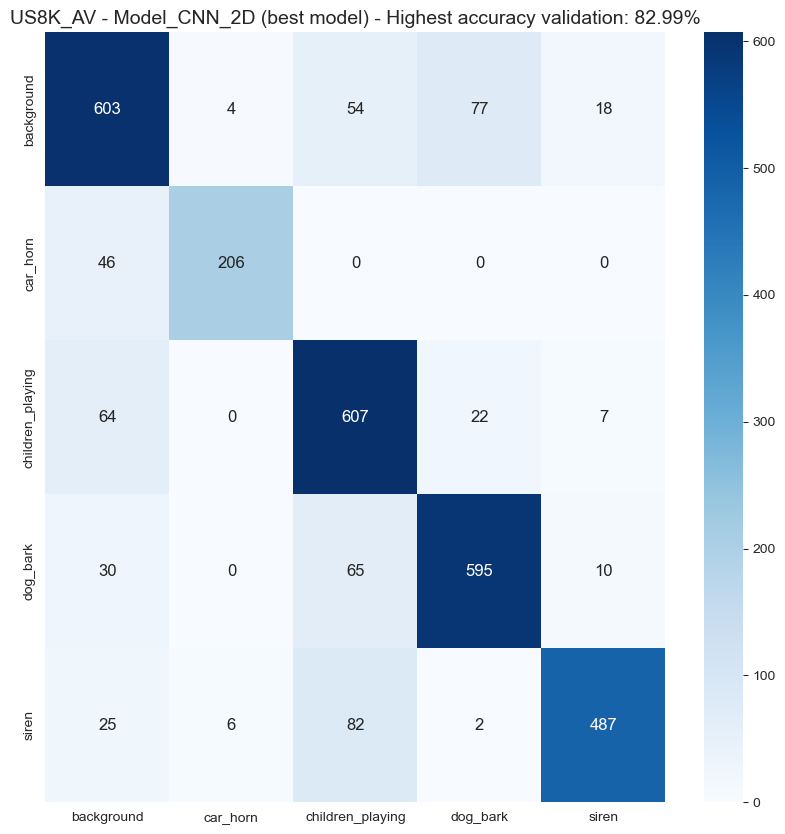

In [98]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_2D_saved, 
                      score_CNN_2D_saved, 
                      cmap_cm, 
                      'Model_CNN_2D_confusion_matrix',
                      ax = None,
                      savepic = False)

### Feature extraction evaluation on the validation set

Select the original audio for the validation set

In [99]:
val_audioW = np.array(DB_aug_from_pkl_VAL.Audio.to_list())
val_audioW.shape

(3010, 22016)

In [100]:
val_audio = np.array(DB_ori_from_pkl_VAL.Audio.to_list())
val_audio

array([[ 6.40211074e-05,  8.26949836e-05,  5.21230577e-05, ...,
        -9.90534551e-04, -1.04527897e-03, -1.12278771e-03],
       [-1.63099641e-04, -1.47700383e-04, -1.09524306e-04, ...,
         8.95090925e-04,  1.02632504e-03,  1.10134820e-03],
       [ 2.32642919e-01,  3.51767898e-01,  2.96772093e-01, ...,
         1.11169368e-01,  8.34129453e-02,  5.04262894e-02],
       ...,
       [-1.33019298e-01, -1.66331232e-01, -1.35999262e-01, ...,
         1.03915721e-01,  1.94399461e-01,  5.43059632e-02],
       [ 3.92560661e-02,  7.70680532e-02,  1.03511095e-01, ...,
         1.14013448e-01,  7.45912045e-02,  8.32999796e-02],
       [ 1.45196602e-01,  1.46330804e-01,  7.95801356e-02, ...,
        -1.42012641e-01, -8.45199227e-02, -3.31722349e-02]], dtype=float32)

In [101]:
val_audio.shape

(430, 88200)

In [102]:
y_val_audio_cat = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())
y_val_audio_cat

array(['dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'siren', 'siren', 'siren', 'siren',
       'background', 'background', 'background', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'background', 'background', 'background',
       'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'siren', 'siren', 'siren'

In [103]:
y_val_audio_cat.shape

(430,)

In [104]:
y_val_audio_cat[1]

'dog_bark'

In [105]:
y_val_audio = np.array(DB_ori_from_pkl_VAL.Class_OHEV.to_list())
y_val_audio

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [106]:
y_val_audio.shape

(430, 5)

In [107]:
ipd.Audio(val_audio[0], rate = SR)

### Quantization of the neural network models

Conversion of hdf5 files to Tensorflow lite (tflite):

* Model_ANN_weights_0_best_norm_windowed.hdf5
* Model_CNN_1D_weights_0_best_norm_windowed.hdf5
* Model_CNN_2D_weights_0_best_windowed.hdf5

In [108]:
print(model_ANN_saved)
print(model_CNN_1D_saved)
print(model_CNN_2D_saved)

In [110]:
#Convert to tflite
converter_ANN   = tf.lite.TFLiteConverter.from_keras_model(model_ANN_saved)
converter_CNN1D = tf.lite.TFLiteConverter.from_keras_model(model_CNN_1D_saved)
converter_CNN2D = tf.lite.TFLiteConverter.from_keras_model(model_CNN_2D_saved)

#Implement optimization strategy for smaller model sizes
converter_ANN.optimizations   = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
converter_CNN1D.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
converter_CNN2D.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size

tflite_model_ANN   = converter_ANN.convert()
open(os.path.join(path_modelsVal, 'Model_ANN_weights_0_best_norm_windowed.tflite'), "wb").write(tflite_model_ANN)

tflite_model_CNN1D = converter_CNN1D.convert()
open(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.tflite'), "wb").write(tflite_model_CNN1D)

tflite_model_CNN2D   = converter_CNN2D.convert()
open(os.path.join(path_modelsVal, 'Model_CNN_2D_weights_0_best_windowed.tflite'), "wb").write(tflite_model_CNN2D)

INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmpddyw9dp_\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmpddyw9dp_\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmpz1_htwnn\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmpz1_htwnn\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp5r0n18ze\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp5r0n18ze\assets


235696

### Inference of the tflite models

In [111]:
# Load the TFLite model and allocate tensors

interpreter_ANN   = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_ANN_weights_0_best_norm_windowed.tflite'))
interpreter_ANN.allocate_tensors()

interpreter_CNN1D = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.tflite'))
interpreter_CNN1D.allocate_tensors()

interpreter_CNN2D = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_CNN_2D_weights_0_best_windowed.tflite'))
interpreter_CNN2D.allocate_tensors()

In [112]:
# Get input and output tensors.
input_details_ANN    = interpreter_ANN.get_input_details()
output_details_ANN   = interpreter_ANN.get_output_details()

input_details_CNN1D  = interpreter_CNN1D.get_input_details()
output_details_CNN1D = interpreter_CNN1D.get_output_details()

input_details_CNN2D  = interpreter_CNN2D.get_input_details()
output_details_CNN2D = interpreter_CNN2D.get_output_details()

In [113]:
input_details_ANN

[{'name': 'Input_input',
  'index': 0,
  'shape': array([  1, 375]),
  'shape_signature': array([ -1, 375]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [114]:
output_details_ANN

[{'name': 'Identity',
  'index': 13,
  'shape': array([1, 5]),
  'shape_signature': array([-1,  5]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [115]:
input_details_CNN1D

[{'name': 'Conv1D_1_input',
  'index': 0,
  'shape': array([  1, 375,   1]),
  'shape_signature': array([ -1, 375,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [116]:
output_details_CNN1D

[{'name': 'Identity',
  'index': 35,
  'shape': array([1, 5]),
  'shape_signature': array([-1,  5]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [117]:
input_details_CNN1D

[{'name': 'Conv1D_1_input',
  'index': 0,
  'shape': array([  1, 375,   1]),
  'shape_signature': array([ -1, 375,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [118]:
output_details_CNN2D

[{'name': 'Identity',
  'index': 44,
  'shape': array([1, 5]),
  'shape_signature': array([-1,  5]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [119]:
input_shape_ANN   = input_details_ANN[0]['shape']
input_shape_CNN1D = input_details_CNN1D[0]['shape']
input_shape_CNN2D = input_details_CNN2D[0]['shape']

print(f'Input shape ANN:....{input_shape_ANN}')
print(f'Input shape CNN1D...{input_shape_CNN1D}')
print(f'Input shape CNN2D...{input_shape_CNN2D}')

Input shape ANN:....[  1 375]
Input shape CNN1D...[  1 375   1]
Input shape CNN2D...[  1 180  44   1]


#### Convert the input data to the expected format of the tflite model

In [120]:
print(input_details_ANN[0]['dtype'])
print(input_details_CNN1D[0]['dtype'])
print(input_details_CNN2D[0]['dtype'])

<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


In [121]:
type(X_val_norm[0][0])

numpy.float64

In [123]:
X_val_norm_tflite = X_val_norm.astype(input_details_ANN[0]['dtype'])
print(X_val_norm_tflite.shape)
print(type(X_val_norm_tflite[0][0]))

(3010, 375)
<class 'numpy.float32'>


### Inference ANN tflite

In [124]:
input_details_ANN[0]['shape']

array([  1, 375])

In [125]:
t = X_val_norm_tflite[0].reshape(1,-1).shape
t

(1, 375)

In [126]:
interpreter_ANN.set_tensor(input_details_ANN[0]['index'], X_val_norm_tflite[0].reshape(1,-1))

In [127]:
interpreter_ANN.invoke()

In [128]:
prediction_tflite_ANN = np.argmax(interpreter_ANN.get_tensor(output_details_ANN[0]['index']), axis=1)
prediction_tflite_ANN

array([3], dtype=int64)

In [129]:
predictions_tflite_ANN= []

for sample in X_val_norm_tflite:
    interpreter_ANN.set_tensor(input_details_ANN[0]['index'], sample.reshape(1,-1))
    interpreter_ANN.invoke()
    prediction_sample_ANN = np.argmax(interpreter_ANN.get_tensor(output_details_ANN[0]['index']), axis=1)
    predictions_tflite_ANN.append(prediction_sample_ANN[0])

predictions_tflite_ANN = np.array(predictions_tflite_ANN)

In [130]:
predictions_tflite_ANN

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [132]:
#predictions_tflite_ANN.tofile(os.path.join(path_arrays, '_saved_predict_val_ANN_tflite.csv'), sep=',')

In [133]:
y_pred_ANN_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [138]:
# Accuracy DECREASED a little compared to the original model

np.array_equal(y_pred_ANN_saved, predictions_tflite_ANN)

False

In [139]:
metrics_set_tflite_ANN = classification_report(y_test_enc, 
                                               predictions_tflite_ANN, 
                                               target_names=nom_classes,
                                               output_dict=False)
print(metrics_set_tflite_ANN)

                  precision    recall  f1-score   support

      background       0.89      0.79      0.83       756
        car_horn       0.84      0.95      0.89       252
children_playing       0.73      0.86      0.79       700
        dog_bark       0.78      0.84      0.81       700
           siren       0.90      0.73      0.81       602

        accuracy                           0.82      3010
       macro avg       0.83      0.83      0.83      3010
    weighted avg       0.83      0.82      0.82      3010



In [140]:
metrics_set_tflite_ANN = classification_report(y_test_enc, 
                                               predictions_tflite_ANN, 
                                               target_names=nom_classes,
                                               output_dict=True)
print(metrics_set_tflite_ANN['accuracy'])

0.8182724252491694


In [ ]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_ANN, 
                      metrics_set_tflite_ANN['accuracy'], 
                      cmap_cm, 
                      'Model_ANN_tflite_confusion_matrix')

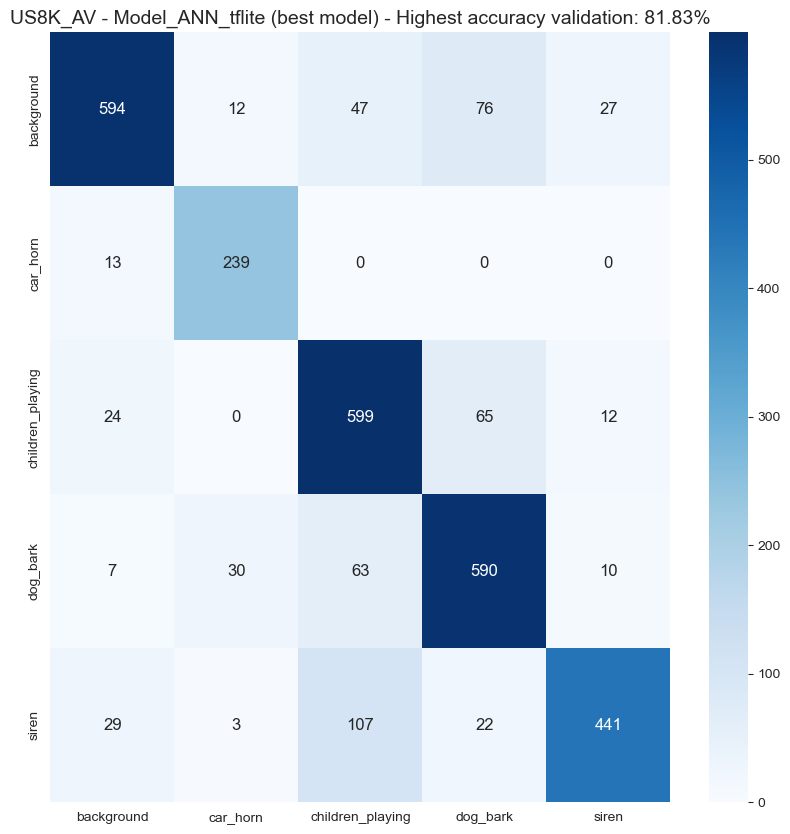

In [141]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_ANN, 
                      metrics_set_tflite_ANN['accuracy'], 
                      cmap_cm, 
                      'Model_ANN_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Inference CNN 1D

In [142]:
input_details_CNN1D[0]['shape']

array([  1, 375,   1])

In [144]:
t = X_val_norm_tflite[0].reshape(1,-1,1).shape
t

(1, 375, 1)

In [145]:
interpreter_CNN1D.set_tensor(input_details_CNN1D[0]['index'], X_val_norm_tflite[0].reshape(1,-1,1))

In [146]:
interpreter_CNN1D.invoke()

In [147]:
prediction_tflite_CNN1D = np.argmax(interpreter_CNN1D.get_tensor(output_details_CNN1D[0]['index']), axis=1)
prediction_tflite_CNN1D

array([3], dtype=int64)

In [148]:
predictions_tflite_CNN1D= []

for sample in X_val_norm_tflite:
    interpreter_CNN1D.set_tensor(input_details_CNN1D[0]['index'], sample.reshape(1,-1,1))
    interpreter_CNN1D.invoke()
    prediction_sample_CNN1D = np.argmax(interpreter_CNN1D.get_tensor(output_details_CNN1D[0]['index']), axis=1)
    predictions_tflite_CNN1D.append(prediction_sample_CNN1D[0])

predictions_tflite_CNN1D = np.array(predictions_tflite_CNN1D)

In [149]:
predictions_tflite_CNN1D

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [150]:
#predictions_tflite_CNN1D.tofile(os.path.join(path_arrays, '_saved_predict_val_CNN1D_tflite.csv'), sep=',')

In [151]:
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [155]:
# Accuracy INCREASED a little compared to the original model

np.array_equal(predictions_tflite_CNN1D, y_pred_CNN_1D_saved)

False

In [153]:
metrics_set_tflite_CNN1D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN1D, 
                                                 target_names=nom_classes,
                                                 output_dict=False)
print(metrics_set_tflite_CNN1D)

                  precision    recall  f1-score   support

      background       0.83      0.74      0.78       756
        car_horn       0.84      0.88      0.86       252
children_playing       0.70      0.76      0.73       700
        dog_bark       0.76      0.85      0.80       700
           siren       0.80      0.71      0.76       602

        accuracy                           0.78      3010
       macro avg       0.79      0.79      0.79      3010
    weighted avg       0.78      0.78      0.78      3010



In [154]:
metrics_set_tflite_CNN1D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN1D, 
                                                 target_names=nom_classes,
                                                 output_dict=True)
print(metrics_set_tflite_CNN1D['accuracy'])

0.7770764119601329


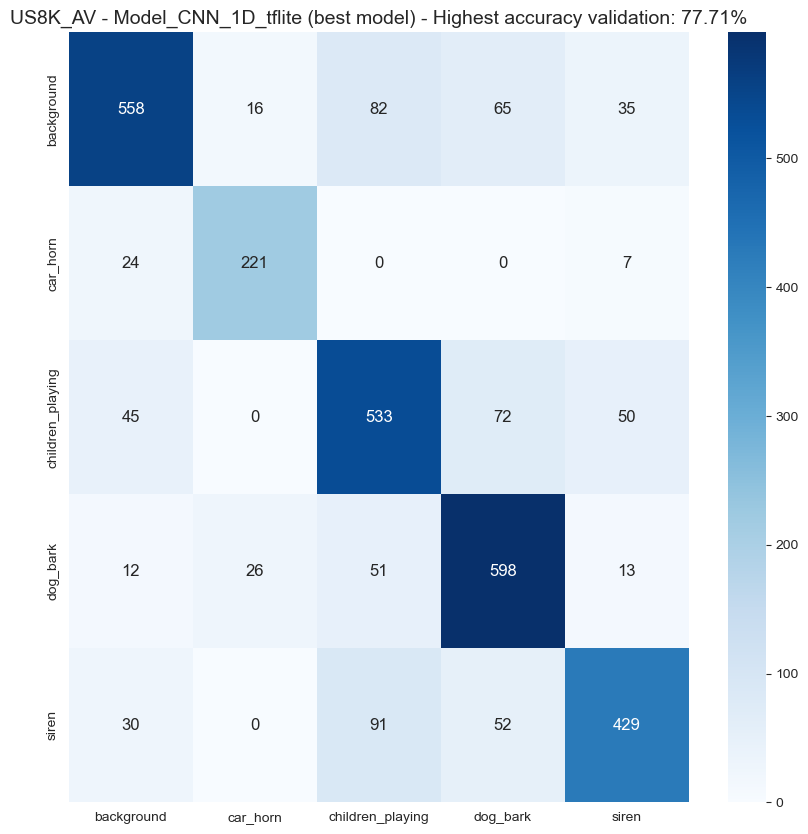

In [156]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN1D, 
                      metrics_set_tflite_CNN1D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_1D_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Inference CNN 2D

In [157]:
input_details_CNN2D[0]['shape']

array([  1, 180,  44,   1])

In [158]:
type(X_val_CNN2D[0][0][0][0])

numpy.float32

In [159]:
X_val_CNN2D[0].shape

(180, 44, 1)

In [160]:
t = X_val_CNN2D[0].reshape(1,-1,44,1)
t.shape

(1, 180, 44, 1)

In [161]:
interpreter_CNN2D.set_tensor(input_details_CNN2D[0]['index'], X_val_CNN2D[0].reshape(1,-1,44,1))

In [162]:
interpreter_CNN2D.invoke()

In [163]:
prediction_tflite_CNN2D = np.argmax(interpreter_CNN2D.get_tensor(output_details_CNN2D[0]['index']), axis=1)
prediction_tflite_CNN2D

array([3], dtype=int64)

In [164]:
predictions_tflite_CNN2D= []

for sample in X_val_CNN2D:
    interpreter_CNN2D.set_tensor(input_details_CNN2D[0]['index'], sample.reshape(1,-1,44,1))
    interpreter_CNN2D.invoke()
    prediction_sample_CNN2D = np.argmax(interpreter_CNN2D.get_tensor(output_details_CNN2D[0]['index']), axis=1)
    predictions_tflite_CNN2D.append(prediction_sample_CNN2D[0])

predictions_tflite_CNN2D = np.array(predictions_tflite_CNN2D)

In [165]:
predictions_tflite_CNN2D

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [168]:
#predictions_tflite_CNN2D.tofile(os.path.join(path_arrays, '_saved_predict_val_CNN2D_tflite.csv'), sep=',')

In [169]:
y_pred_CNN_2D_saved 

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [172]:
# Accuracy INCREASED a little compared to the original model

np.array_equal(y_pred_CNN_2D_saved, predictions_tflite_CNN2D)

False

In [173]:
metrics_set_tflite_CNN2D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN2D, 
                                                 target_names=nom_classes,
                                                 output_dict=False)
print(metrics_set_tflite_CNN2D)

                  precision    recall  f1-score   support

      background       0.79      0.79      0.79       756
        car_horn       0.96      0.82      0.88       252
children_playing       0.75      0.87      0.81       700
        dog_bark       0.85      0.85      0.85       700
           siren       0.93      0.81      0.86       602

        accuracy                           0.83      3010
       macro avg       0.86      0.83      0.84      3010
    weighted avg       0.84      0.83      0.83      3010



In [174]:
metrics_set_tflite_CNN2D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN2D, 
                                                 target_names=nom_classes,
                                                 output_dict=True)
print(metrics_set_tflite_CNN2D['accuracy'])

0.8302325581395349


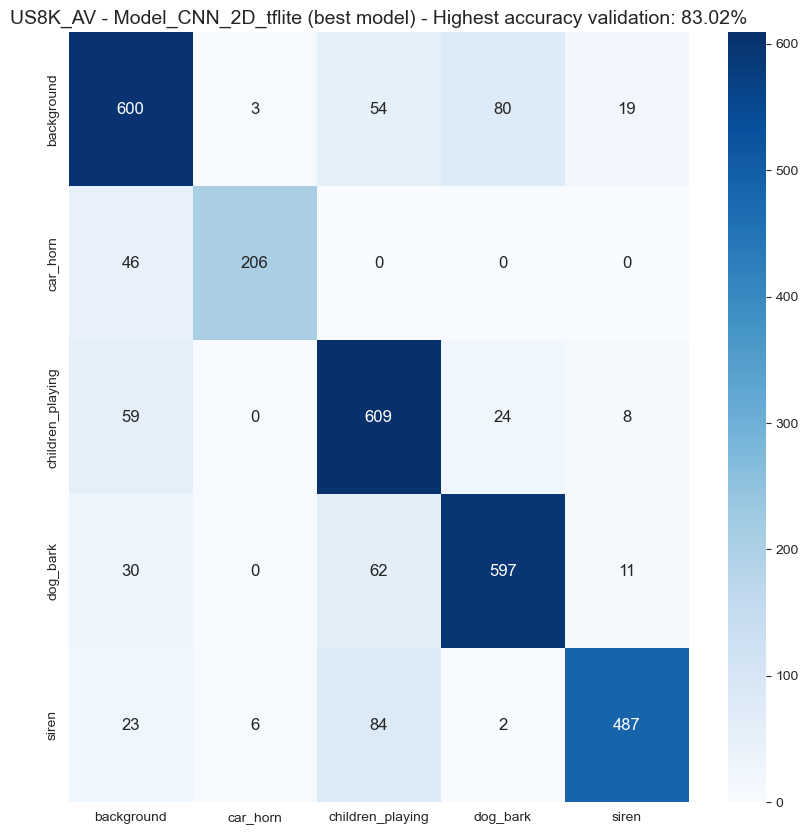

In [176]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN2D, 
                      metrics_set_tflite_CNN2D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_2D_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Neural network models - Comparison between the decision matrices original x quantization

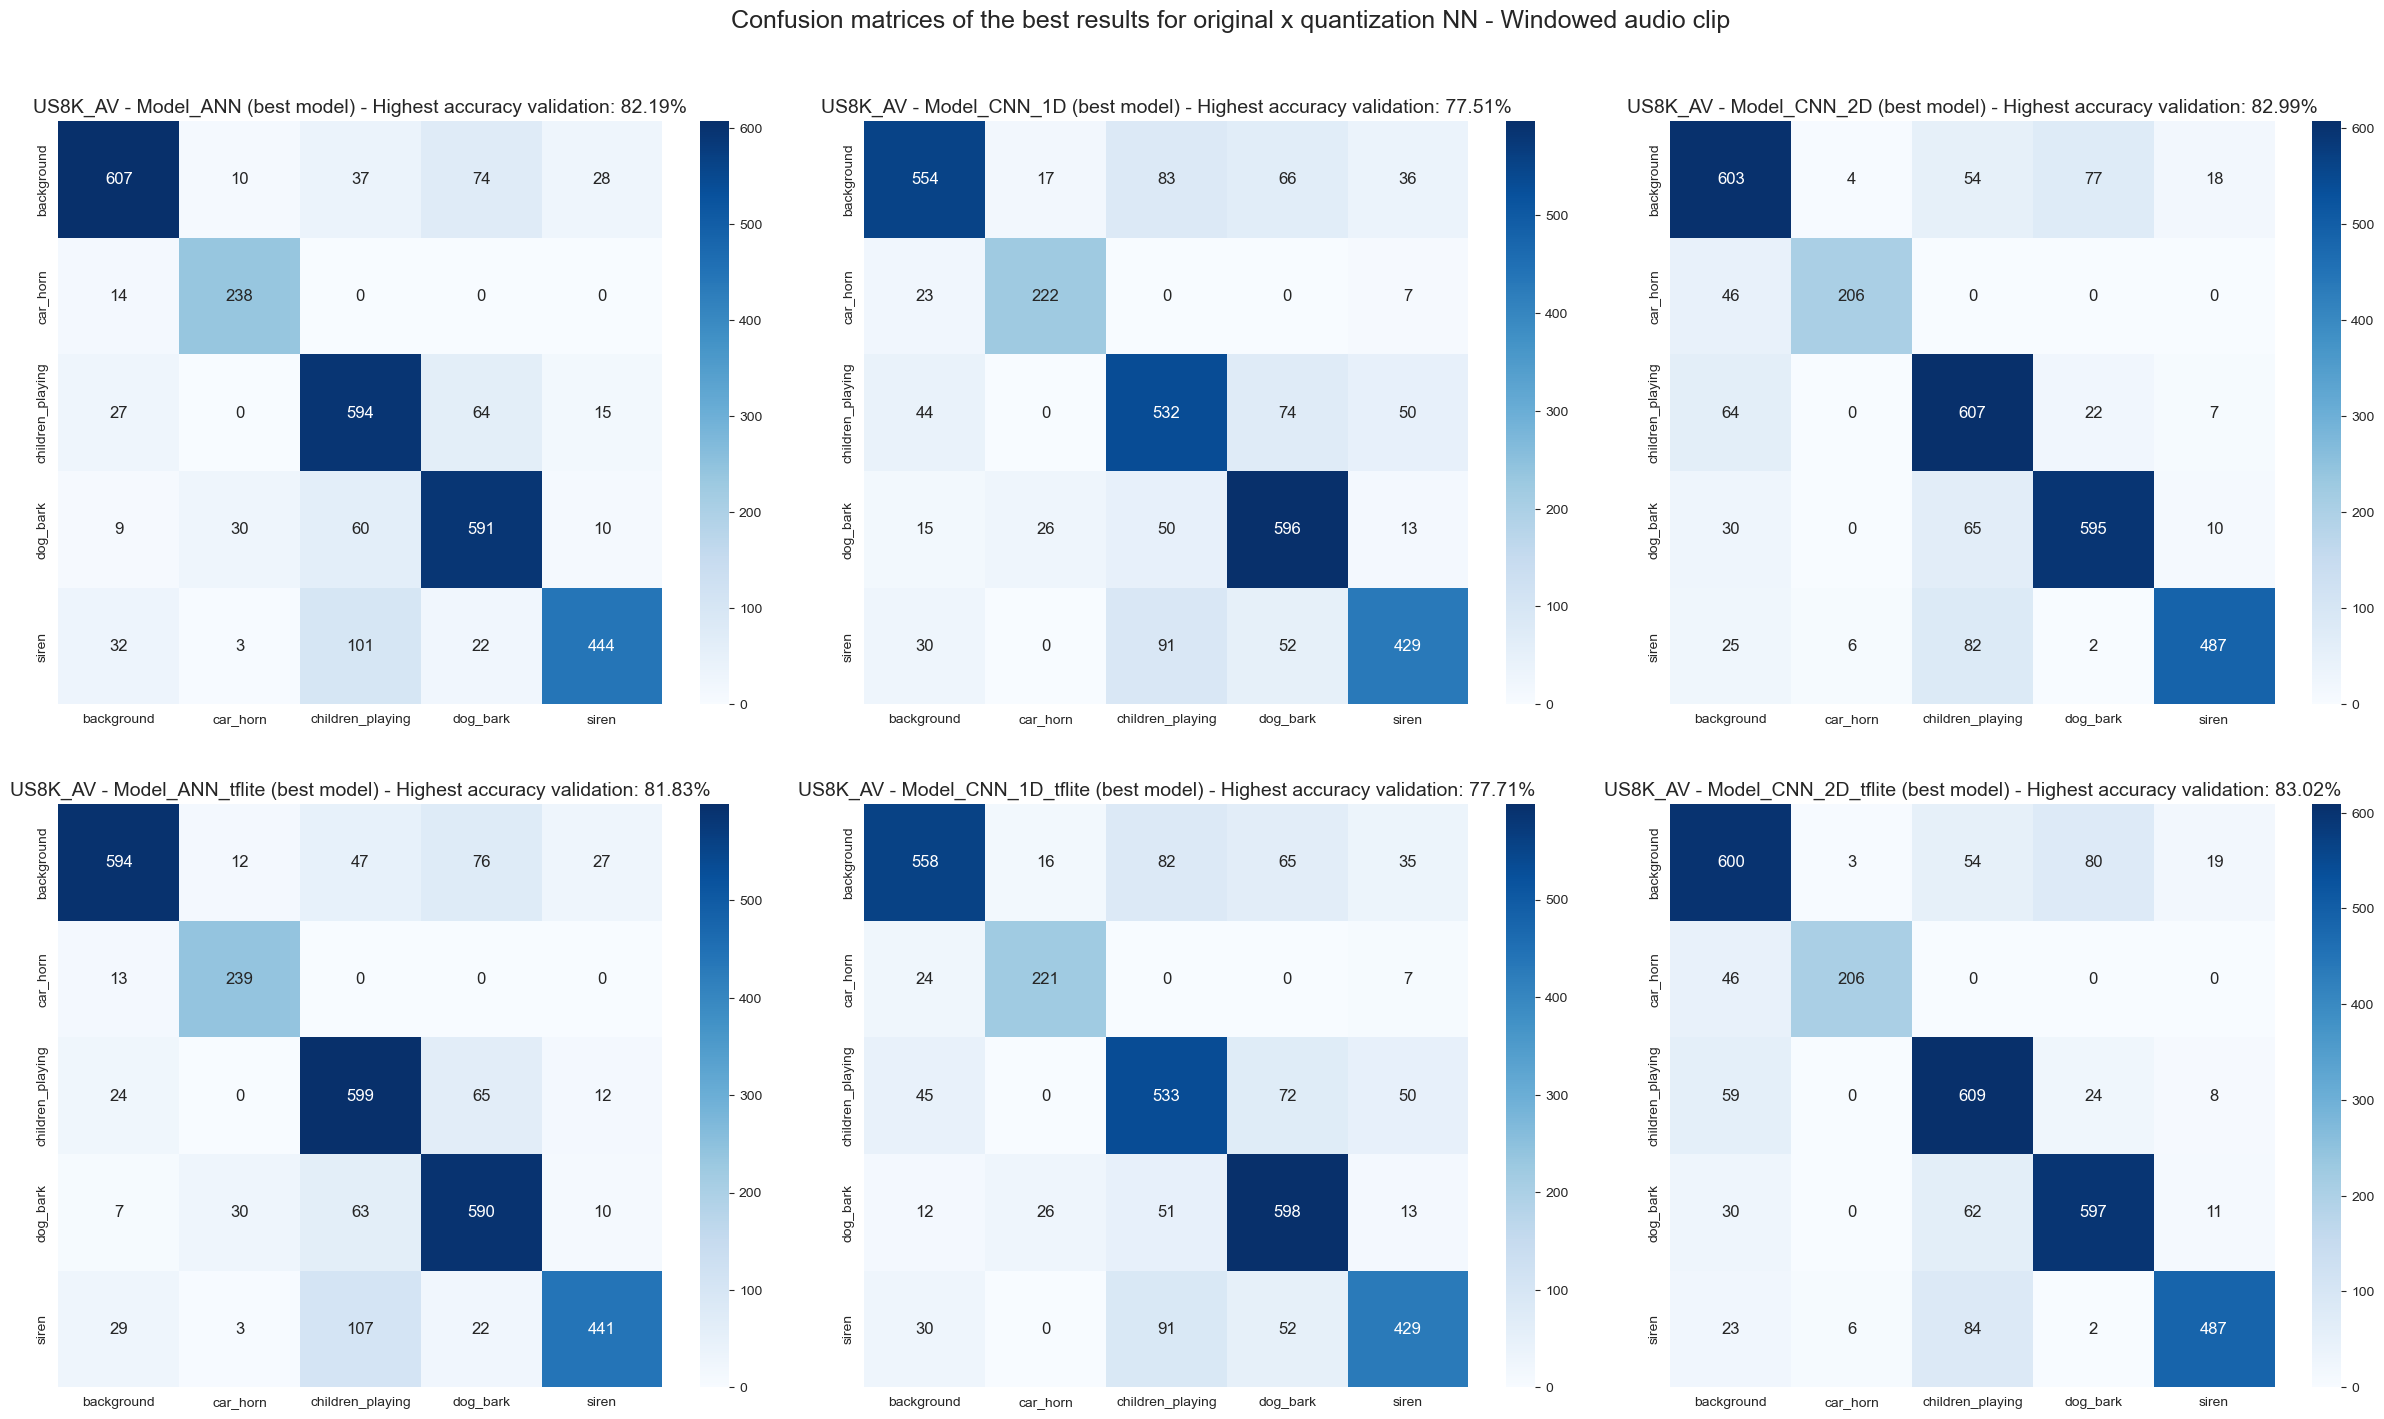

In [181]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, axs = plt.subplots(2, 3, figsize=(25,15))
plt.suptitle('Confusion matrices of the best results for original x quantization NN - Windowed audio clip', fontsize = 18,  y=0.97)


plot_confusion_matrix(y_test_enc, 
                      y_pred_ANN_saved, 
                      score_ANN_saved, 
                      cmap_cm, 
                      'Model_ANN_confusion_matrix',
                      ax=axs[0,0],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_1D_saved, 
                      score_CNN_1D_saved, 
                      cmap_cm, 
                      'Model_CNN_1D_confusion_matrix',
                      ax=axs[0,1],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_2D_saved, 
                      score_CNN_2D_saved, 
                      cmap_cm, 
                      'Model_CNN_2D_confusion_matrix',
                      ax=axs[0,2],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_ANN, 
                      metrics_set_tflite_ANN['accuracy'], 
                      cmap_cm, 
                      'Model_ANN_tflite_confusion_matrix',
                      ax=axs[1,0],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN1D, 
                      metrics_set_tflite_CNN1D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_1D_tflite_confusion_matrix',
                      ax=axs[1,1],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN2D, 
                      metrics_set_tflite_CNN2D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_2D_tflite_confusion_matrix',
                      ax=axs[1,2],
                      savepic = False)

plt.tight_layout(pad=4)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

# End of the notebook